# Developing a typology of aid donors with quantitative methods: Part I: Pricipal Components Analysis

# 1. Introduction

In this project, I develop a typology of aid donors using quantitative methods. The first part is about Principal Component Analysis (PCA). The second part about Clustering will be available in a separate notebook in the same repository when it's ready).

A typology is a method in social sciences that classifies observations according to attributes they expose on a range of different variables. Research about development cooperation uses aid donor typologies to describe similarities and differences in the way how states and other actors provide assistance to developing countries. Generally used concepts or labels include "Scandinavian donors" or "Arab donors". A major distinction is also drawn between the donors of the OECD's Development Assistance Committee (DAC) and providers of South-South Cooperation. These typologies do not usually result from a pure application of statistical methods, but are the product of qualitative judgements and a historically grown domain-specific vocabulary.

I do not intend to present a full overview and explanation of typologies and concepts used in the academic literature. Instead, I will focus on presenting two quantitative approaches (PCA and Clustering) that can contribute to developing typologies and making reasoning about typologies more evidence-based, explicit and objective. However, I do not argue that running some fancy quantitative methods alone is sufficient to develop a robust typology. The methods I present here can play a complementary role to support qualitative research guided by domain expertise.

The first part of this project applies Principal Component Analysis to a dataset about aid donors. The main idea of PCA is to reduce the dimensionality of a data set with many interrelated variables, and retaining most of the information (i.e. variation) of the original dataset. This is achieved by creating new variables, the principal components (PCs). The PCs are uncorrelated and ordered so that the first few PCs contain most of the variation of the original variables.

How can PCA help us with developing a typology? First of all, we can use the lower-dimensional data coming out of the PCA to visualise aid donors in two- or three-dimensional space. This would allow us to visually identify groups of donors that are closer together than others. A meaningful interpretation of the resulting visualisation, however, is not guaranteed. The quality of the 3D-representation depends on how much of the original information is retained in the first three dimensions of the new, reduced data set. Spoiler alert: In the case of this example, the first three principal components provide an interesting perspective, but (at least with my current data set) we would need more than three dimensions to build a robust typology. But all is not in vain. We can use the results from the PCA as an input to another method: Clustering. To be continued ...

I have published a post about this notebook on my blog where you can find additional information about this project.

### Outline:

1. Introduction
2. Data Collection
3. Exploratory Analysis and building the dataset
4. Principal Component Analysis: visualising aid donors in 3D
5. Interpretation of results
6. Another round of PCA
7. Conclusion


## 2. Data collection

I use data from the OECD Development Assistance Committee (DAC). The dataset I'm building here has certain limitations. First, the data focuses on DAC members, but also includes a group of "Participants" and some other countries that share data with the DAC. The data therefore excludes some of the big players that are not reporting data to the DAC, such as China, India and Brazil. Second, I focus on Official Development Assistance (ODA). Although ODA constitutes an important source of development finance for the poorest developing countries, it is not the only and, depending on which countries we are looking at, not the most important source of finance. It would be possible to include other financial flows, but I want to keep the project manageable. Finally, I only include bilateral official donors (i.e. not private foundations or EU Institutions).

The csv files used in this notebook come from [OECD statistics](https://stats.oecd.org/) under the category "Development". Some files were downloaded from the OECD's [Query Wizard for International Development Statistics](https://stats.oecd.org/qwids/).

I use the following six csv files. Their specific shape and form depends on how they were queried on the OECD's database platforms.
- General data about the quantity of aid (absolute/as share of GNI/etc.): `data/oda_data_general.csv`
- geographic distribution of ODA (aid per world regions and recipient countries, type of income groups, and other country categories): `data/donors_recipients.csv`
- ODA by sector: `data/oda_by_sectors.csv`
- types of aid and channels of delivery: `data/crs_ge.csv`
- use of the multilateral system: `data/multilateral.csv`
- country-programmable aid: `data/cpa.csv`

I conduct the PCA on data for the year 2020 only. It would be possible to do a multi-year typology or to track changes in the typology over several years, but I want to keep it simple. The same can be said about the choice of variables in the next section. Other choices are possible, depending on the purpose of the typology you want to create. As the motivation for this project is mostly a methodological one, I set myself a limit for the data preparation part because this could be endless if one wants to delve into all the details of the data.

Donors include DAC donors and non-DAC donors ("Participants" and others) reporting data to the DAC (excluding the EU institutions). Donor names appear as in the original OECD data.

In [498]:
# there are 30 DAC members
dac_members = ["Australia", "Austria", "Belgium", "Canada", "Czech Republic", "Belgium", "Denmark",
               "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy",
               "Japan", "Korea", "Luxembourg", "Netherlands", "New Zealand", "Norway", "Poland",
               "Portugal", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Switzerland",
               "United Kingdom", "United States"]

# 7 countries participate in the DAC as non-members
participants = ["Azerbaijan", "Bulgaria", "Kuwait", "Qatar", "Romania", "Saudi Arabia", "United Arab Emirates"]

# There are more countries that report data to the DAC. They will also be included in the analysis.
# e.g. Thailand, Türkiye, etc.

## 3. Data exploration and preparation

In this part, I go through the csv files and explore the data with the help of some basic descriptive statistics and data visualisations. The main objective of this chapter is to identify the variables that could be used in the PCA and prepare the data accordingly.

As in most data projects, data exploration and preparation take up the biggest part of the code. In this version of the notebook, I will not explain every single detail of this section due to time constraints. The main purpose is to make transparent how I arrive at the final, cleaned-up data set that will serve as an input to the PCA.

In [499]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import io

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from functools import reduce
from typing import Optional

sns.set_style("dark")
pal = sns.color_palette()

### 3.1 How much ODA do countries give?

I don't want to make differences in donor size an important factor in the typology. Otherwise, we would end up having a typology that differentiates between small and big donors, and we don't need PCA to see this difference. That is why I will only retain the share of GNI as a criterium. However, we need to pay attention to what extent donor size influences other criteria (if big donors simply do things differently than smaller donors). We will not be able to avoid this completely, but we'll check correlations between donor size and other variables later.

ODA data from this file is measured according to grant equivalency. Grant equivalents have become the standard to measure ODA. In simple language, this is a way to measure how much of the money donors provide really stays with developing countries (e.g. it takes into account that loans will partly have to be paid back to the donor, and translates the amount to what it would be worth as a "pure" grant).

Financial values are in millions of USD (constant 2020).

In [500]:
oda_data = pd.read_csv("data/oda_data_general.csv")

In [501]:
# we create a new dataframe that only contains the data we want to use
mask_oda_ge = (oda_data['Fund flows'] == "Grant equivalents") \
                & (oda_data['Amount type'] == "Constant Prices") \
                & (oda_data['Aid type'] == 'Official Development Assistance, grant equivalent measure')
mask_oda_gni = oda_data['Aid type'] == 'ODA grant equivalent as percent of GNI'

masks = {'oda_ge': mask_oda_ge, 'oda_gni': mask_oda_gni}


def create_oda_main_df(raw_df: pd.DataFrame, masks: dict[str, bool],
                       dac_members: list[str], participants: list[str]) -> pd.DataFrame:
    oda_absolute = raw_df.loc[mask_oda_ge, ['Donor', 'Value']].rename(
        columns={'Value': 'ODA, grant equivalent measure'})
    oda_gni = raw_df.loc[mask_oda_gni, ['Donor', 'Value']].rename(
        columns={'Value': 'ODA grant equivalent as percent of GNI'})
    oda_main = oda_absolute.merge(oda_gni, on='Donor')
    oda_main['status'] = oda_main['Donor'].apply(lambda x: 'DAC' if x in dac_members
                                             else 'Participant' if x in participants
                                             else 'Aggregate' if ('total' in x.lower())
                                             else 'Other')
    return oda_main

In [502]:
oda_main = create_oda_main_df(oda_data, masks, dac_members, participants)

In [503]:
oda_main.head()

,Donor,"ODA, grant equivalent measure",ODA grant equivalent as percent of GNI,status
0,Portugal,412.99,0.184026,DAC
1,Poland,829.25,0.143632,DAC
2,Lithuania,72.02,0.132920,Other
3,Sweden,6348.62,1.138910,DAC
4,Italy,4248.38,0.223411,DAC


In [504]:
oda_main.describe(include='all')

,Donor,"ODA, grant equivalent measure",ODA grant equivalent as percent of GNI,status
count,48,48.000000,48.000000,48
unique,48,NaN,NaN,4
top,Portugal,NaN,NaN,DAC
freq,1,NaN,NaN,29
mean,NaN,7056.727500,0.341844,NaN
std,NaN,24001.063245,0.294427,NaN
min,NaN,14.830000,0.012986,NaN
25%,NaN,128.582500,0.135461,NaN
50%,NaN,710.365000,0.257281,NaN
75%,NaN,3721.067500,0.470310,NaN


In [505]:
# distributions are skewed, let's also keep our variables as log transformed versions
oda_main['ODA, grant equivalent measure (log)'] = oda_main['ODA, grant equivalent measure'].apply(lambda x: np.log10(x))
oda_main['ODA as percent of GNI (log)'] = oda_main['ODA grant equivalent as percent of GNI'].apply(lambda x: np.log10(1.0 + x))

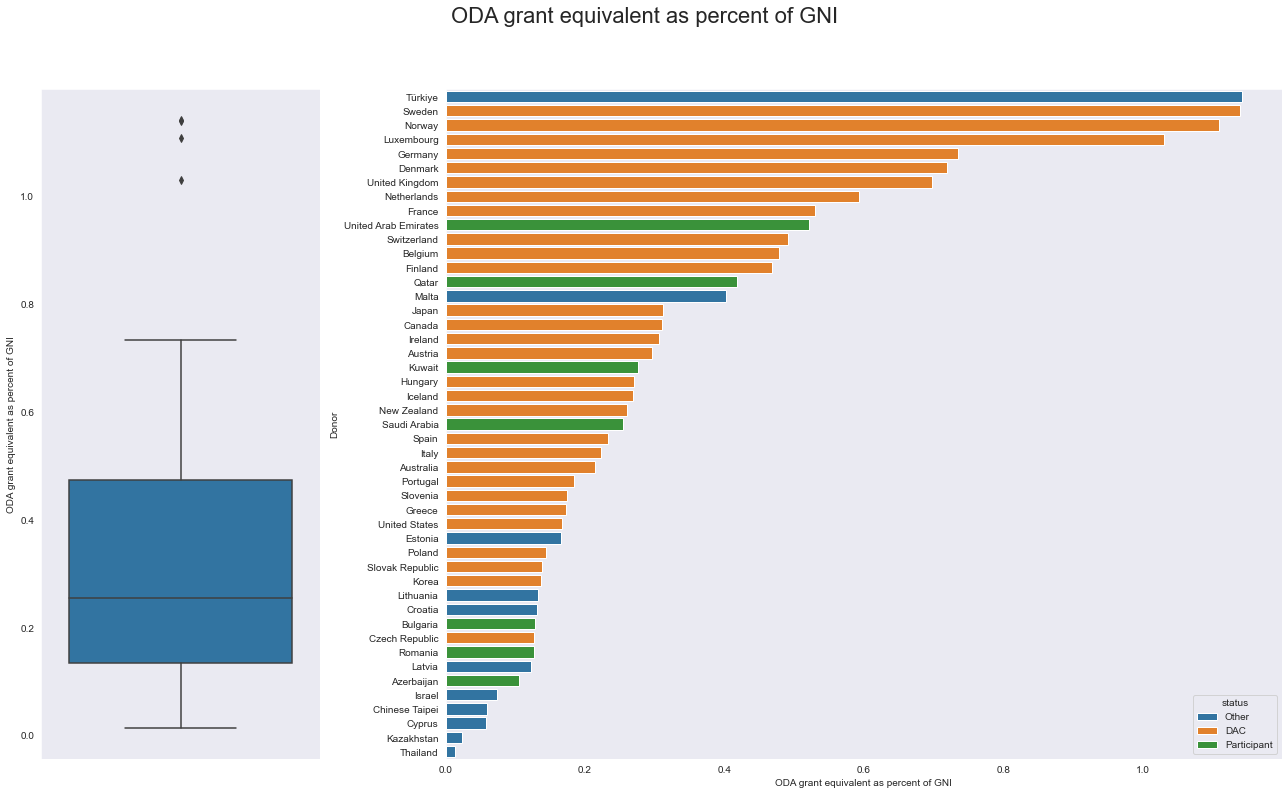

In [506]:
countries = [donor for donor in oda_main['Donor'].unique()
             if donor != 'DAC Countries, Total']

only_countries = oda_main['Donor'].isin(countries)

fig1, (ax1a, ax1b) = plt.subplots(figsize=(18, 10), ncols=2, gridspec_kw={'width_ratios': [1, 3]})

sns.boxplot(data=oda_main.loc[only_countries, :], y="ODA grant equivalent as percent of GNI", ax=ax1a);
sns.barplot(data=oda_main.loc[only_countries, :].sort_values(by="ODA grant equivalent as percent of GNI", ascending=False),
            y="Donor", x="ODA grant equivalent as percent of GNI", hue='status',ax=ax1b, dodge=False, orient='h');
fig1.tight_layout()
fig1.suptitle('ODA grant equivalent as percent of GNI', size=22, y=1.1)

plt.show()

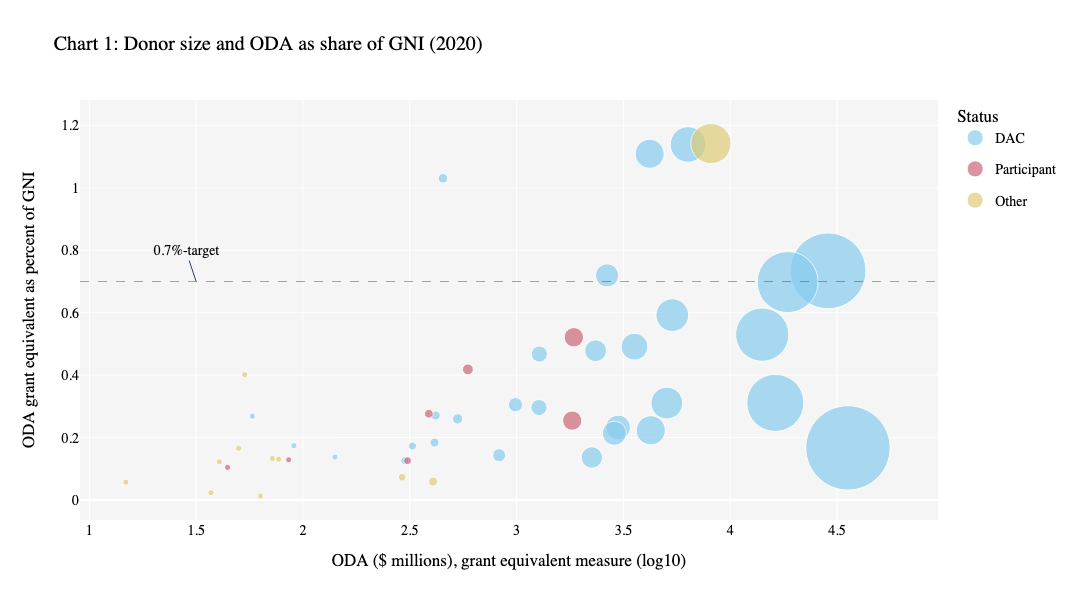

In [507]:
status_colors = px.colors.qualitative.Safe[:3]
status_in_order = ['DAC', 'Participant', 'Other']

fig2 = go.Figure()

for status, color in zip(status_in_order, status_colors):
    trace_mask = oda_main['status'] == status
    trace_data = oda_main.loc[trace_mask, :]
    fig2.add_trace(
        go.Scatter(x=trace_data['ODA, grant equivalent measure (log)'],
                   y=trace_data['ODA grant equivalent as percent of GNI'],
                   name=status,
                   mode='markers',
                   marker=dict(
                            color=color,
                            sizemin=3,
                            sizemode='area',
                            sizeref=10,
                            size=trace_data['ODA, grant equivalent measure'],
                        ),
                    text=trace_data['Donor'],
                    hovertemplate="%{text} <br>Share of GNI: %{y:.2f}% <br>Total: %{marker.size:$,.2f} million",
                    legendgroup=status,
                    showlegend=True
                )
    )
fig2.add_hline(y=0.7, line_width=0.5, line_dash="dash", line_color="red")
fig2.add_annotation(x=1.5, y=0.70, text='0.7%-target')

fig2.update_layout(title='Chart 1: Donor size and ODA as share of GNI (2020)', font_family='Montserrat', font_color='black',
                   font_size=14,
                   legend=dict(title='Status'), plot_bgcolor='rgb(245, 245, 245)',
                   width=800, height=600)
fig2.update_xaxes(title="ODA ($ millions), grant equivalent measure (log10)")
fig2.update_yaxes(title="ODA grant equivalent as percent of GNI")
fig2.show()

### 3.2 ODA geographic flows

In this section, I'll look into three sets of potential variables for the PCA:

- 3.2.1 Aid by world region, including a measure of regional concentration.

- 3.2.2 Aid by income groups: poverty focus.

- 3.2.3 Aid to specific groups of countries (fragile states, landlocked countries, small-island states).

If not otherwise specified, data is about bilateral gross disbursements to countries, regions or country groups.

In [508]:
# We will first load the file containing the geographic data and create three dataframes for the three sub-sections.
geo_df = pd.read_csv("data/donors_recipients.csv", header=1, index_col=0)
geo_df.drop(axis=0, index='Donor(s)', inplace=True)
geo_df.drop(axis=1, columns=['Recipient(s)'], inplace=True)
geo_df = geo_df.replace('..', '0.0').astype(float)

***

#### A note on missing data

Values marked as `..` in the files mean that nothing has been reported for that value. This means that `..` can have two different meanings. Sometimes it can just be replaced with `0.0`. For instance, if donor A has not reported any ODA for region B, this is equivalent to saying that ODA was `0.0` for that region. On the other hand, `..` should be interpreted as missing data if the entire row of a donor is marked as `..` for all regions, including the total.

In practice, it is sufficient to just replace `..` with `0.0`. When we convert into shares (e.g. region C divided by total), this will be `0.0` if the total is not `0.0`, otherwise NaN. This is valid for all the other files as well. In this version of the notebook, I will not keep donors that have missing values for any of the variables used in the PCA. Alternatively, it would be possible to replace missing values with values from earlier years.

***

In [509]:
geo_df.head()

,"All Developing Countries, Total","North of Sahara, Total","South of Sahara, Total","Caribbean & Central America, Total","South America, Total","Middle East, Total","South & Central Asia, Total","Far East Asia, Total","Europe, Total","Oceania, Total",...,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Wallis and Futuna,West Bank and Gaza Strip,Yemen,Zambia,Zimbabwe,Unnamed: 161
"DAC Countries, Total",128893.56,3993.15,30306.16,3537.17,4658.45,11115.78,15645.52,10051.69,3786.26,1892.45,...,677.69,92.13,233.71,1388.66,107.0,817.24,1608.93,615.17,575.58,NaN
"Non-DAC Countries, Total",14586.23,849.14,1772.34,415.36,86.06,8814.29,636.88,314.30,349.04,9.22,...,55.43,0.17,24.30,28.29,0.0,376.00,540.00,30.05,2.56,NaN
Australia,2318.95,0.09,51.90,0.67,1.82,69.54,232.81,434.65,4.82,786.45,...,0.00,54.15,0.00,43.46,0.0,13.07,0.00,1.08,1.05,NaN
Austria,568.21,8.86,69.08,25.63,8.85,45.08,42.97,18.21,132.09,0.78,...,0.53,0.38,1.51,3.40,0.0,5.60,1.30,0.12,0.30,NaN
Belgium,1175.95,15.24,433.63,20.67,29.75,74.12,5.06,20.81,13.80,0.00,...,0.29,0.00,0.00,6.10,0.0,20.80,15.33,1.36,0.72,NaN


## Divide data about recipient groups into three tables: region, income group, other groups

In [510]:
def change_col_names_pct(col_names: list[str]) -> list[str]:
    """
    Change column names from 'xyz, Total' to 'xyz (%)'
    """
    return [col.replace(', Total', ' (%)') for col in col_names]
    

regions = [
    'North of Sahara, Total',
    'South of Sahara, Total',
    'Europe, Total',
    'Caribbean & Central America, Total',
    'South America, Total',
    'Middle East, Total',
    'South & Central Asia, Total',
    'Far East Asia, Total',
    'Oceania, Total'
]

regions_pct = change_col_names_pct(regions)

income_groups = [
    'LDCs, Total',
    'Other LICs, Total',
    'LMICs, Total',
    'UMICs, Total'
]

income_pct = change_col_names_pct(income_groups)

other_groups_cols = [
    'All Developing Countries, Total',
    'Fragile states, Total',
    'Land-Locked countries, Total',
    'Small island states, Total'
]

other_groups_cols_pct = change_col_names_pct(other_groups_cols[1:])

In [511]:
regions_df = geo_df.loc[:, regions]
income_df = geo_df.loc[:, income_groups]
other_groups = geo_df.loc[:, other_groups_cols]

I will usually transform values from absolute values to percentage shares compared to some specified total. This is more appropriate for PCA and makes the variables less dependent on donor size.

I define some helper functions that will be used several times to convert valuea to percentages and regroup columns.
- convert_to_percentages
- aggregate_cols


In [512]:
def convert_to_percentages(df: pd.DataFrame, col_names: list[str],
                           new_col_names: list[str], total_col: Optional[str] = None) \
                                                            -> pd.DataFrame:
    """
    Helper function to convert absolute values into shares compared to a total.
    
    Parameters:
    - df: the Dataframe to be converted
    - col_names: the columns of df to be converted
    - new_col_names: column names to be used for converted columns
    - total_col: optional total to calculate shares, if not present total will be sum of columns
    """
    if not total_col:
        total_col = 'Total'
        df[total_col] = df.loc[:, col_names].sum(axis=1)
    df = df.loc[:, col_names].div(df[total_col], axis=0)
    df.dropna(axis=0, inplace=True)
    if total_col in df.columns:
        df.drop(columns=[total_col], inplace=True)
    df.columns = new_col_names
    return df


def aggregate_cols(df: pd.DataFrame, instructions: dict[str, list[str]]) -> pd.DataFrame:
    """
    Helper function to regroup columns. Can also be used to change column names.
    Aggregation means adding the values of the columns.
    
    Parameters:
    - df: dataframe with columns to aggregate
    - instructions: mapping linking new column names with old column(s), e.g. {'AplusB': ['A', 'B']}
    """
    for sum_col, cols in instructions.items():
        df[sum_col] = 0.0
        for col in cols:
            df[sum_col] += df[col]
        df.drop(columns=cols, inplace=True)
    return df

### 3.2.1 Regional ODA allocation

In [513]:
regions_df =  convert_to_percentages(regions_df, regions, regions_pct)

In [514]:
regions_df.head()

,North of Sahara (%),South of Sahara (%),Europe (%),Caribbean & Central America (%),South America (%),Middle East (%),South & Central Asia (%),Far East Asia (%),Oceania (%)
"DAC Countries, Total",0.046986,0.356599,0.044551,0.041620,0.054814,0.130794,0.184094,0.118274,0.022268
"Non-DAC Countries, Total",0.064102,0.133796,0.026349,0.031356,0.006497,0.665399,0.048079,0.023727,0.000696
Australia,0.000057,0.032791,0.003045,0.000423,0.001150,0.043936,0.147092,0.274617,0.496888
Austria,0.025203,0.196501,0.375736,0.072906,0.025174,0.128232,0.122230,0.051799,0.002219
Belgium,0.024858,0.707298,0.022509,0.033715,0.048525,0.120898,0.008253,0.033943,0.000000


In [515]:
regions_df.describe()

,North of Sahara (%),South of Sahara (%),Europe (%),Caribbean & Central America (%),South America (%),Middle East (%),South & Central Asia (%),Far East Asia (%),Oceania (%)
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.051941,0.265123,0.203737,0.027658,0.031891,0.161600,0.138367,0.082414,0.037269
std,0.131343,0.248204,0.299713,0.043754,0.048915,0.185886,0.156626,0.139816,0.141234
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001758,0.034585,0.021570,0.002519,0.002222,0.048811,0.045497,0.010581,0.000000
50%,0.007936,0.191775,0.041493,0.012470,0.014401,0.113277,0.112068,0.034229,0.000119
75%,0.041245,0.467010,0.304901,0.032516,0.047252,0.173065,0.173243,0.093807,0.004804
max,0.672489,0.782704,0.929012,0.224549,0.313524,0.962492,1.000000,0.869176,0.744070


Let's have a closer look at the distributions ...

In [516]:
reg_dis_df = regions_df.reset_index().melt(id_vars=['index'],
                                           value_vars=regions_pct,
                                           var_name="regions")

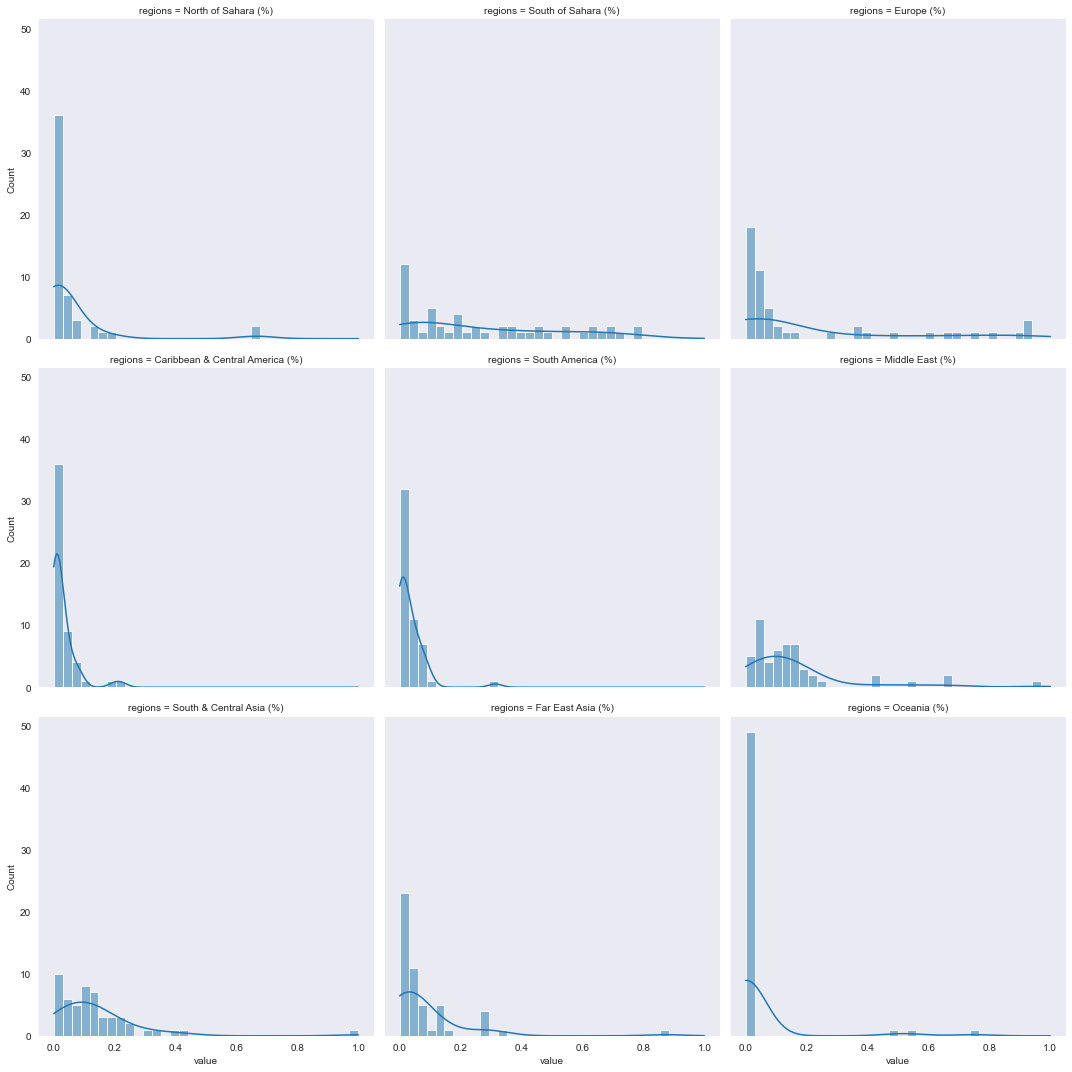

In [517]:
sns.displot(reg_dis_df, x="value", col="regions", col_wrap=3, kind='hist', kde=True);

#### Add variable describing regional concentration

Count regions where a given donor disburses more than 25% of total ODA and divide by number of regions with meaningful presence (at least 3%). I take the log10 transformation. Donors that are very specialised regionally will have a score close to zero, scores of more regionally dispersed donors will tend more towards -1.

The variables oda_presence and oda_focus can be adapted.

In [518]:
oda_presence = 0.03
oda_focus = 0.25

regions_df['regional_dispersion'] = (regions_df.loc[:, regions_pct] >= oda_presence).sum(axis=1)
regions_df['focus_regions'] = (regions_df.loc[:, regions_pct] > oda_focus).sum(axis=1)
regions_df['concentration_score'] = (regions_df['focus_regions'] / regions_df['regional_dispersion']).apply(lambda x: np.log10(x))
regions_df.drop(columns=['regional_dispersion', 'focus_regions'], inplace=True)

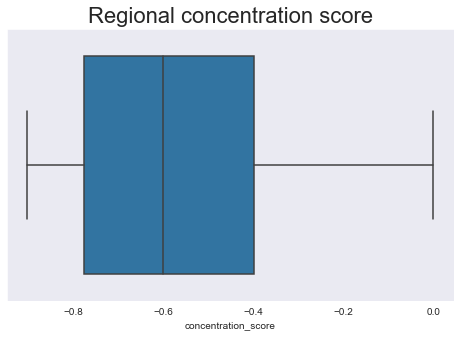

In [519]:
fig3, ax3 = plt.subplots(figsize=(8, 5))

sns.boxplot(x=regions_df['concentration_score'], ax=ax3)
plt.title("Regional concentration score", fontsize=22)
plt.show()

### Aggregate regions

In [520]:
aggregate_geo_cols = {
                'Asia-Pacific (%)': ['Far East Asia (%)', 'Oceania (%)'],
                'MENA (%)': ['Middle East (%)', 'North of Sahara (%)'],
                'America (%)': ['South America (%)', 'Caribbean & Central America (%)'],
                'Sub-Saharan Africa (%)': ['South of Sahara (%)']
            }

regions_df = aggregate_cols(regions_df, aggregate_geo_cols)

In [521]:
# update list of columns
regions_pct = list(regions_df.columns)
regions_pct.remove('concentration_score')

In [522]:
regions_df.head()

,Europe (%),South & Central Asia (%),concentration_score,Asia-Pacific (%),MENA (%),America (%),Sub-Saharan Africa (%)
"DAC Countries, Total",0.044551,0.184094,-0.903090,0.140541,0.177780,0.096434,0.356599
"Non-DAC Countries, Total",0.026349,0.048079,-0.698970,0.024423,0.729501,0.037853,0.133796
Australia,0.003045,0.147092,-0.397940,0.771505,0.043993,0.001573,0.032791
Austria,0.375736,0.122230,-0.778151,0.054018,0.153435,0.098080,0.196501
Belgium,0.022509,0.008253,-0.698970,0.033943,0.145756,0.082240,0.707298


### Visualise regional variables

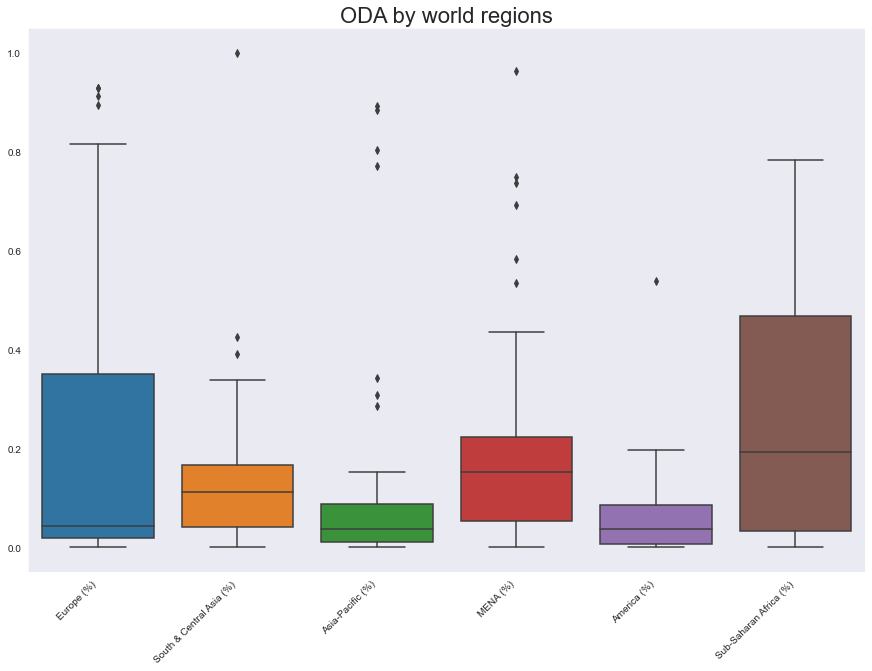

In [523]:
exclude_donor = ['DAC Countries, Total', 'Non-DAC Countries, Total', 'Other donor countries']

show_countries = [donor for donor in regions_df.index if donor not in exclude_donor]

fig4, ax4 = plt.subplots(figsize=(15, 10)) 
sns.boxplot(data=regions_df.loc[show_countries, regions_pct], ax = ax4)
plt.title("ODA by world regions", fontsize=22)
plt.xticks(rotation=45, ha="right")
plt.show()

## 3.2.2 ODA by income group

In [524]:
income_df.head()

,"LDCs, Total","Other LICs, Total","LMICs, Total","UMICs, Total"
"DAC Countries, Total",31411.90,591.53,31345.24,15961.10
"Non-DAC Countries, Total",2389.25,70.02,9298.28,1151.74
Australia,472.94,1.05,767.61,179.10
Austria,56.59,0.33,112.82,143.87
Belgium,415.76,0.72,104.94,77.80


In [525]:
income_df = convert_to_percentages(income_df, income_groups, income_pct)

In [526]:
income_df.head()

,LDCs (%),Other LICs (%),LMICs (%),UMICs (%)
"DAC Countries, Total",0.396066,0.007458,0.395225,0.201250
"Non-DAC Countries, Total",0.185080,0.005424,0.720278,0.089218
Australia,0.332892,0.000739,0.540304,0.126065
Austria,0.180447,0.001052,0.359746,0.458755
Belgium,0.693835,0.001202,0.175128,0.129835


In [527]:
income_df.describe()

,LDCs (%),Other LICs (%),LMICs (%),UMICs (%)
count,52.000000,52.000000,52.000000,52.000000
mean,0.338981,0.003483,0.370712,0.286824
std,0.269886,0.006735,0.239263,0.260544
min,0.000000,0.000000,0.000000,0.000000
25%,0.073823,0.000000,0.178074,0.114530
50%,0.292143,0.000703,0.337895,0.164237
75%,0.551808,0.003238,0.464240,0.406157
max,0.918129,0.030355,0.998921,1.000000


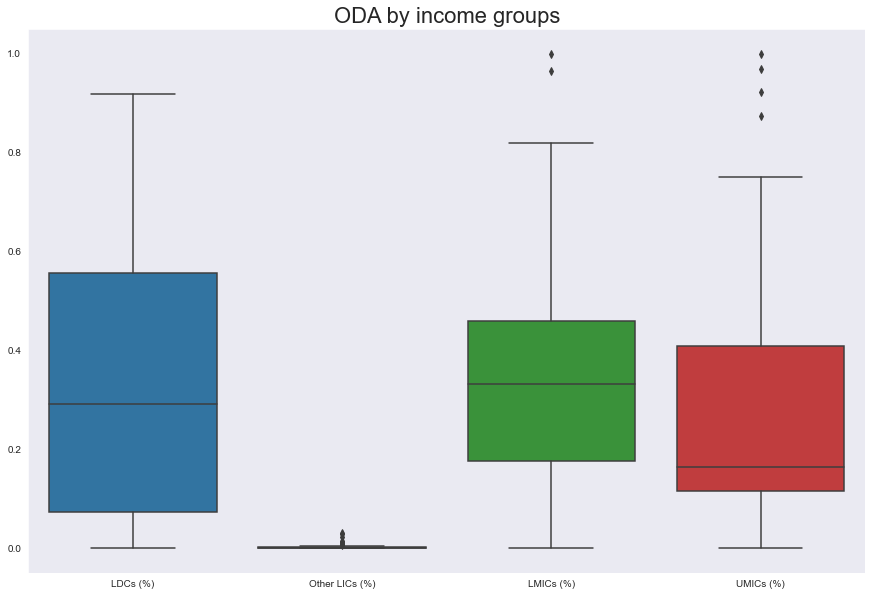

In [528]:
fig5, ax5 = plt.subplots(figsize=(15, 10)) 
sns.boxplot(data=income_df.loc[show_countries, :], ax = ax5)
plt.title("ODA by income groups", fontsize=22)
plt.show();

In [529]:
aggregate_income_cols = {
                'poor country focus (%)': ['LDCs (%)', 'Other LICs (%)']
            }

income_df = aggregate_cols(income_df, aggregate_income_cols)

### Keep only 'poor country focus'

In [530]:
# we delete LMICs and UMICs and only keep poor country focus
income_df.drop(columns=['LMICs (%)', 'UMICs (%)'], inplace=True)

In [531]:
income_df.head()

,poor country focus (%)
"DAC Countries, Total",0.403524
"Non-DAC Countries, Total",0.190504
Australia,0.333631
Austria,0.181499
Belgium,0.695037


## 3.2.3 ODA by other groups: fragile states, land-locked countries, and small-island states

In [532]:
other_groups.head()

,"All Developing Countries, Total","Fragile states, Total","Land-Locked countries, Total","Small island states, Total"
"DAC Countries, Total",128893.56,42307.59,16389.21,3264.96
"Non-DAC Countries, Total",14586.23,10252.56,714.87,498.76
Australia,2318.95,861.02,94.84,736.42
Austria,568.21,106.08,62.77,16.58
Belgium,1175.95,407.70,216.97,12.36


In [533]:
# Note important to use All Developing Countries as total because these are overlapping groups.
other_groups = convert_to_percentages(other_groups, other_groups_cols, other_groups_cols_pct,
                                      total_col='All Developing Countries, Total')

In [534]:
other_groups.head()

,Fragile states (%),Land-Locked countries (%),Small island states (%)
"DAC Countries, Total",0.328237,0.127153,0.025331
"Non-DAC Countries, Total",0.702893,0.049010,0.034194
Australia,0.371297,0.040898,0.317566
Austria,0.186692,0.110470,0.029179
Belgium,0.346698,0.184506,0.010511


In [535]:
other_groups.describe()

,Fragile states (%),Land-Locked countries (%),Small island states (%)
count,53.000000,53.000000,53.000000
mean,0.288501,0.140750,0.030764
std,0.218915,0.149609,0.078028
min,0.000000,0.000000,0.000000
25%,0.121557,0.049010,0.000517
50%,0.281865,0.104359,0.005089
75%,0.371297,0.173401,0.025473
max,0.903810,0.752238,0.410997


In [536]:
dis_other_groups = other_groups.reset_index().melt(
        id_vars=['index'],
        value_vars=other_groups_cols_pct,
        var_name="types of country"
    )

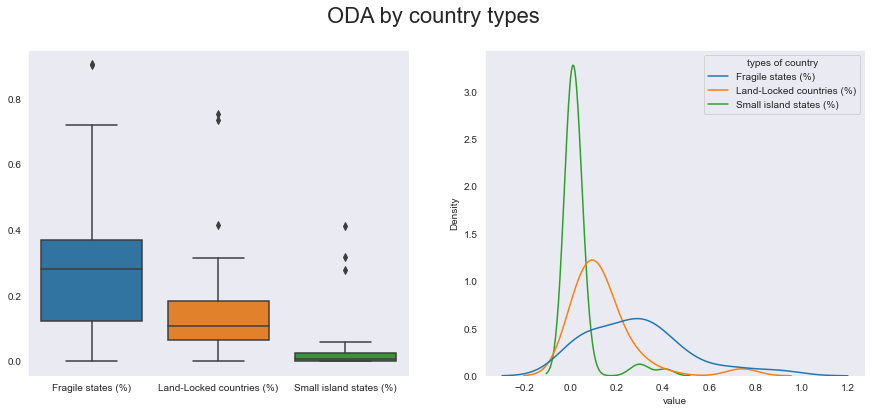

In [537]:
fig6, (ax6a, ax6b) = plt.subplots(figsize=(15, 6), ncols=2)

sns.boxplot(data=other_groups.loc[show_countries, :], ax = ax6a)
sns.kdeplot(data=dis_other_groups, x="value", hue="types of country", ax=ax6b)
fig6.suptitle("ODA by country types", fontsize=22)
plt.show()

## 3.3 ODA by sector

In [538]:
sectors_df = pd.read_csv("data/oda_by_sectors.csv")
sectors_df = sectors_df.pivot(index='Donor', columns='Sector', values='Value')
sectors_df = sectors_df.fillna(0.0)

In [539]:
sectors_df.columns

Index(['Administrative Costs of Donors, Total',
       'I. Social Infrastructure & Services, Total', 'I.1. Education, Total',
       'I.2. Health, Total',
       'I.3. Population Policies/Programmes & Reproductive Health, Total',
       'I.4. Water Supply & Sanitation, Total',
       'I.5. Government & Civil Society, Total',
       'I.6. Other Social Infrastructure & Services, Total',
       'II. Economic Infrastructure & Services, Total',
       'II.1. Transport & Storage, Total', 'II.2. Communications, Total',
       'II.3. Energy, Total', 'II.4. Banking & Financial Services, Total',
       'II.5. Business & Other Services, Total',
       'III. Production Sectors, Total',
       'III.1. Agriculture, Forestry, Fishing, Total',
       'III.2. Industry, Mining, Construction, Total',
       'III.3.a. Trade Policies & Regulations, Total',
       'III.3.b. Tourism, Total', 'IV. Multi-Sector / Cross-Cutting, Total',
       'IV.1. General Environment Protection, Total',
       'IV.2. Other M

In [540]:
sector_cols = [
        'Total All Sectors',
        'I.1. Education, Total',
        'I.2. Health, Total',
        'I.3. Population Policies/Programmes & Reproductive Health, Total',
        'I.4. Water Supply & Sanitation, Total',
        'I.5. Government & Civil Society, Total',
        'I.6. Other Social Infrastructure & Services, Total',
        'II.1. Transport & Storage, Total',
        'II.2. Communications, Total',
        'II.3. Energy, Total',
        'II.4. Banking & Financial Services, Total',
        'II.5. Business & Other Services, Total',
        'III. Production Sectors, Total',
        'III.1. Agriculture, Forestry, Fishing, Total',
        'IV. Multi-Sector / Cross-Cutting, Total',
        'VIII. Humanitarian Aid, Total',
        'VI. Commodity Aid / General Programme Assistance, Total',
        'VII. Action Relating to Debt, Total'
    ]

In [541]:
sectors_df = convert_to_percentages(sectors_df, sector_cols, change_col_names_pct(sector_cols[1:]),
                                    total_col='Total All Sectors')

In [542]:
sectors_df.head()

,I.1. Education (%),I.2. Health (%),I.3. Population Policies/Programmes & Reproductive Health (%),I.4. Water Supply & Sanitation (%),I.5. Government & Civil Society (%),I.6. Other Social Infrastructure & Services (%),II.1. Transport & Storage (%),II.2. Communications (%),II.3. Energy (%),II.4. Banking & Financial Services (%),II.5. Business & Other Services (%),III. Production Sectors (%),"III.1. Agriculture, Forestry, Fishing (%)",IV. Multi-Sector / Cross-Cutting (%),VIII. Humanitarian Aid (%),VI. Commodity Aid / General Programme Assistance (%),VII. Action Relating to Debt (%)
Donor,,,,,,,,,,,,,,,,,
Australia,0.062873,0.147930,0.009685,0.024470,0.159249,0.027448,0.038591,0.006772,0.010413,0.007649,0.018492,0.061864,0.049886,0.163551,0.100423,0.020489,0.000000
Austria,0.288478,0.013028,0.000337,0.027641,0.055004,0.026236,0.000389,0.000471,0.118556,0.050295,0.011328,0.082244,0.061360,0.045941,0.097993,0.004312,0.025918
Azerbaijan,0.091126,0.700870,0.000038,0.000000,0.019087,0.011513,0.031594,0.000000,0.000038,0.000038,0.000000,0.065674,0.063384,0.024191,0.040417,0.000000,0.000000
Belgium,0.092953,0.082088,0.022454,0.021022,0.062146,0.016992,0.007158,0.010119,0.019344,0.000022,0.020669,0.125319,0.090532,0.131305,0.158931,0.000000,0.000000
Bulgaria,0.029316,0.040174,0.000000,0.000000,0.055375,0.080347,0.000000,0.000000,0.000000,0.000000,0.023887,0.000000,0.000000,0.002172,0.244300,0.000000,0.000000


In [543]:
aggregate_sector_cols = {
                'Education (%)': ['I.1. Education (%)'],
                'Health, Water, Sanitation (%)': ['I.2. Health (%)', 'I.3. Population Policies/Programmes & Reproductive Health (%)', 'I.4. Water Supply & Sanitation (%)'],
                'Government, Society and Peace (%)': ['I.5. Government & Civil Society (%)'],
                'Other Social Infrastructure & Services (%)': ['I.6. Other Social Infrastructure & Services (%)'],
                'Transport, Communication and Energy (%)': ['II.1. Transport & Storage (%)', 'II.2. Communications (%)', 'II.3. Energy (%)'],
                'Banking, Finance and Business (%)': ['II.4. Banking & Financial Services (%)', 'II.5. Business & Other Services (%)'],
                'Production sectors (%)': ['III. Production Sectors (%)'],
                'Agriculture, Forestry, Fishing (%)': ['III.1. Agriculture, Forestry, Fishing (%)'],
                'Multi-Sector / Cross-Cutting (%)': ['IV. Multi-Sector / Cross-Cutting (%)'],
                'Commodity Aid / General Programme Assistance (%)': ['VI. Commodity Aid / General Programme Assistance (%)'],
                'Action Relating to Debt (%)': ['VII. Action Relating to Debt (%)'],
                'Humanitarian Aid (%)': ['VIII. Humanitarian Aid (%)']
            }

sectors_df = aggregate_cols(sectors_df, aggregate_sector_cols)

In [544]:
sectors_df['Other production sectors (%)'] = sectors_df['Production sectors (%)'] - sectors_df['Agriculture, Forestry, Fishing (%)']
sectors_df.drop(columns=['Production sectors (%)', 'Commodity Aid / General Programme Assistance (%)', 'Action Relating to Debt (%)'], inplace=True)

In [545]:
sectors_df.index

Index(['Australia', 'Austria', 'Azerbaijan', 'Belgium', 'Bulgaria', 'Canada',
       'Chinese Taipei', 'Croatia', 'Cyprus', 'Czech Republic',
       'DAC Countries, Total', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Kazakhstan', 'Korea', 'Kuwait', 'Latvia', 'Liechtenstein',
       'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand',
       'Non-DAC Countries, Total', 'Norway', 'Poland', 'Portugal', 'Qatar',
       'Romania', 'Saudi Arabia', 'Slovak Republic', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'Thailand', 'Türkiye', 'United Arab Emirates',
       'United Kingdom', 'United States'],
      dtype='object', name='Donor')

In [546]:
sectors_df.describe()

,Education (%),"Health, Water, Sanitation (%)","Government, Society and Peace (%)",Other Social Infrastructure & Services (%),"Transport, Communication and Energy (%)","Banking, Finance and Business (%)","Agriculture, Forestry, Fishing (%)",Multi-Sector / Cross-Cutting (%),Humanitarian Aid (%),Other production sectors (%)
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.124491,0.127365,0.091339,0.022100,0.062918,0.019379,0.034071,0.049848,0.163211,0.013248
std,0.161918,0.128669,0.085092,0.021714,0.115361,0.028567,0.030256,0.048103,0.183676,0.020353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.038275,0.047741,0.016108,0.006994,0.003827,0.000000,0.001548,0.009117,0.051187,0.000194
50%,0.076844,0.112553,0.082610,0.018851,0.027782,0.004237,0.036781,0.033814,0.135984,0.004735
75%,0.123487,0.157328,0.139315,0.028948,0.060088,0.025697,0.058085,0.086421,0.201740,0.017098
max,0.812133,0.700908,0.324306,0.107158,0.587474,0.144850,0.099847,0.169899,0.905127,0.110382


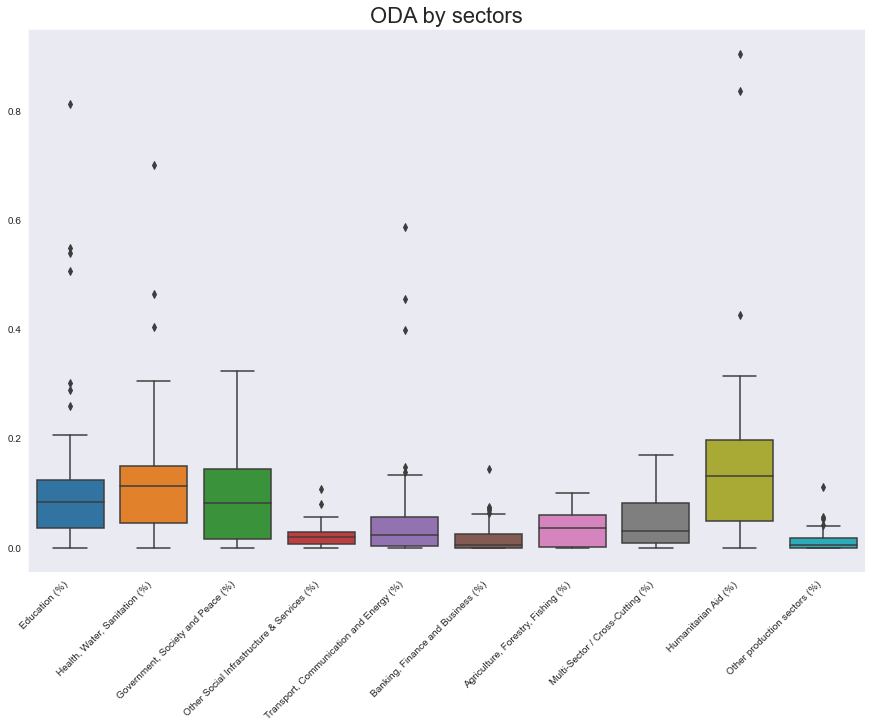

In [547]:
show_countries = [donor for donor in sectors_df.index if donor not in ['Official Donors, Total', 'DAC Countries, Total', 'Non-DAC Countries, Total']]

fig7, ax7 = plt.subplots(figsize=(15, 10)) 
sns.boxplot(data=sectors_df.loc[show_countries, :], ax = ax7)
plt.title("ODA by sectors", fontsize=22)
plt.xticks(rotation=45, ha="right")
plt.show()

In [548]:
drop_cols = ['Other Social Infrastructure & Services (%)', 'Other production sectors (%)']

sectors_df.drop(columns=drop_cols, inplace=True)

***

## Load data from Creditor Reporting System (grant equivalent) for types and channels of aid

The following file contains the data for the sub-sections on aid types and aid channels.

In [549]:
crs = pd.read_csv("data/crs_ge.csv")

In [550]:
crs.head()

,DONOR,Donor,RECIPIENT,Recipient,SECTOR,Sector,FLOW,Flow,CHANNEL,Channel,AMOUNTTYPE,Amount type,AIDTYPE,Type of aid,YEAR,Year,Value,Flag Codes,Flags
0,4,France,10003,"South of Sahara, Total",1000,Total All Sectors,100,Total Bilateral ODA,10000,Public Sector,D,Constant Prices,H,Other in-donor expenditures,2020,2020,0.041208,NaN,NaN
1,3,Denmark,10203,"Fragile states, Total",300,"III. Production Sectors, Total",100,Total Bilateral ODA,60000,Private Sector Institutions,D,Constant Prices,C,Project-type interventions,2020,2020,9.423578,NaN,NaN
2,2,Belgium,10002,"North of Sahara, Total",200,"II. Economic Infrastructure & Services, Total",100,Total Bilateral ODA,10000,Public Sector,D,Constant Prices,C,Project-type interventions,2020,2020,0.338977,NaN,NaN
3,3,Denmark,10003,"South of Sahara, Total",500,VI. Commodity Aid / General Programme Assistan...,100,Total Bilateral ODA,100,All Channels,D,Constant Prices,B,Core contributions and pooled programmes and f...,2020,2020,14.822245,NaN,NaN
4,3,Denmark,10203,"Fragile states, Total",100,"I. Social Infrastructure & Services, Total",100,Total Bilateral ODA,30000,Public-Private Partnerships (PPP),D,Constant Prices,100,"All Types, Total",2020,2020,0.460427,NaN,NaN


In [551]:
channel_mask = (crs['RECIPIENT'] == 10100) & (crs['SECTOR'] == 1000) & (crs['AIDTYPE'] == '100')
type_mask = (crs['RECIPIENT'] == 10100) & (crs['SECTOR'] == 1000) & (crs['CHANNEL'] == 100)
channel_crs = crs.loc[channel_mask, :]
type_crs = crs.loc[type_mask, :]
channel_crs = channel_crs.pivot(index='Donor', columns='Channel', values='Value').astype(float).fillna(0.0)
type_crs = type_crs.pivot(index='Donor', columns='Type of aid', values='Value').astype(float).fillna(0.0)

***

# 3.4 ODA by type of aid

In [552]:
type_crs.head()

Type of aid,Administrative costs not included elsewhere,"All Types, Total",Budget support,Core contributions and pooled programmes and funds,Debt relief,Experts and other technical assistance,Not applicable,Other in-donor expenditures,Project-type interventions,Scholarships and student costs in donor countries
Donor,,,,,,,,,,
Australia,190.797847,2318.952063,37.471398,441.206387,0.000000,253.637569,0.000000,0.000000,1284.474611,111.364251
Austria,35.578289,513.355430,2.279202,116.225618,14.726844,25.251566,47.518572,39.322435,94.571073,137.881831
Azerbaijan,0.000000,33.667804,0.000000,17.279001,0.000000,5.570899,0.000000,0.000000,10.805604,0.012300
Belgium,80.747075,1158.605122,2.279202,503.486121,0.000000,16.806135,63.863248,135.846965,303.290884,52.285492
Bulgaria,0.000000,9.210000,0.000000,0.000000,0.000000,0.000000,0.000000,4.820000,4.390000,0.000000


In [553]:
type_crs = convert_to_percentages(type_crs, list(type_crs.columns),
                                  [f"{col} (%)" for col in type_crs.columns if col != 'All Types, Total'],
                                  total_col='All Types, Total')

In [554]:
aggregate_type_cols = {
            'in-donor expenditures (%)': ['Scholarships and student costs in donor countries (%)', 'Other in-donor expenditures (%)'],
            'Budget support and pooled funding (%)': ['Budget support (%)', 'Core contributions and pooled programmes and funds (%)'],
        }

type_crs = aggregate_cols(type_crs, aggregate_type_cols)
type_crs.drop(columns=['Administrative costs not included elsewhere (%)', 'Debt relief (%)', 'Not applicable (%)'], inplace=True)

In [555]:
type_crs.head()

,Experts and other technical assistance (%),Project-type interventions (%),in-donor expenditures (%),Budget support and pooled funding (%)
Donor,,,,
Australia,0.109376,0.553903,0.048024,0.206420
Austria,0.049189,0.184221,0.345188,0.230844
Azerbaijan,0.165467,0.320948,0.000365,0.513220
Belgium,0.014505,0.261772,0.162378,0.436530
Bulgaria,0.000000,0.476656,0.523344,0.000000


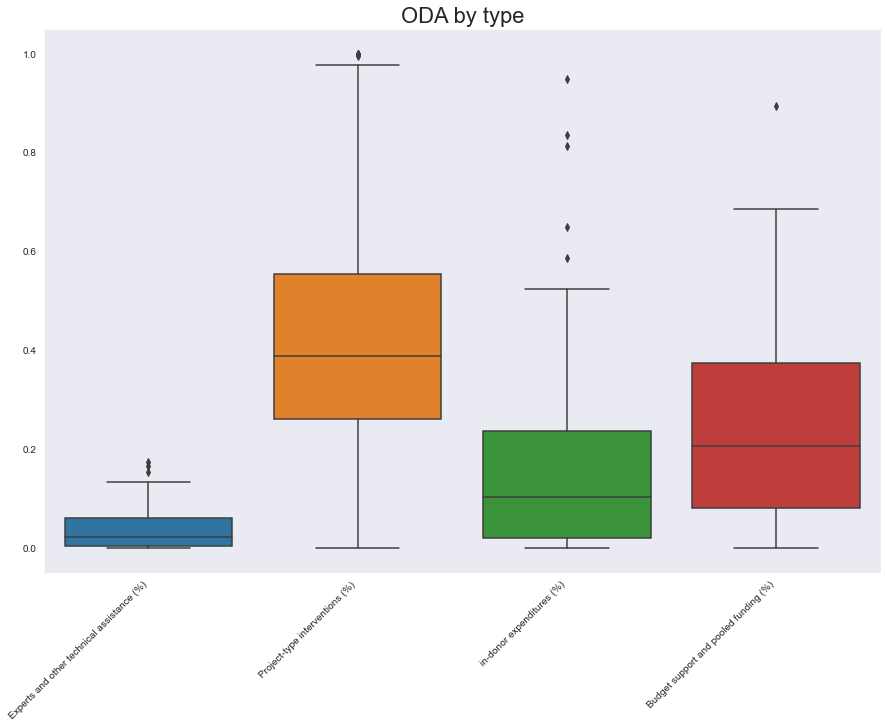

In [556]:
exclude_donors = ['DAC Countries, Total', 'Non-DAC Countries, Total']

show_countries = [donor for donor in type_crs.index if donor not in exclude_donors]

fig8, ax8 = plt.subplots(figsize=(15, 10)) 
sns.boxplot(data=type_crs.loc[show_countries, :], ax = ax8)
plt.xticks(rotation=45, ha="right")
plt.title("ODA by type", fontsize=22)
plt.show()

## 3.5 ODA by delivery channel

In [557]:
channel_crs.head()

Channel,All Channels,Multilateral Organisations,NGOs & Civil Society,Not reported,Other,Private Sector Institutions,Public Sector,Public-Private Partnerships (PPP),"Teaching institutions, research institutes or think-tanks"
Donor,,,,,,,,,
Australia,2318.952063,653.081372,248.630172,0.000000,661.813311,3.278161,487.282039,2.855371,262.011637
Austria,513.355430,109.970981,67.219882,47.518572,7.237278,3.566520,137.547318,3.531980,136.762899
Azerbaijan,33.667804,16.508503,0.064814,0.000000,0.293032,0.000000,16.075771,0.032134,0.693550
Belgium,1158.605122,181.397198,295.262631,63.863248,0.000000,10.491690,421.047629,3.303096,183.239630
Bulgaria,9.210000,0.000000,0.000000,0.000000,0.090000,0.000000,9.120000,0.000000,0.000000


In [558]:
channel_crs = convert_to_percentages(channel_crs, channel_crs.columns,
                                     [f"{col} (%)" for col in channel_crs.columns[1:]],
                                     total_col='All Channels')

In [559]:
aggregate_channel_cols = {
                'Public-Private Partnerships (PPP) and Private Sector (%)': ['Public-Private Partnerships (PPP) (%)', 'Private Sector Institutions (%)'],
                'Other channels (%)': ['Other (%)', 'Not reported (%)'],
                'NGOs, civil society and research institutions (%)': ['NGOs & Civil Society (%)', 'Teaching institutions, research institutes or think-tanks (%)']
            }

channel_crs = aggregate_cols(channel_crs, aggregate_channel_cols)
channel_crs.drop(columns=['Other channels (%)'], inplace=True)

In [560]:
channel_crs.head()

,Multilateral Organisations (%),Public Sector (%),Public-Private Partnerships (PPP) and Private Sector (%),"NGOs, civil society and research institutions (%)"
Donor,,,,
Australia,0.281628,0.210130,0.002645,0.220204
Austria,0.214220,0.267938,0.013828,0.397352
Azerbaijan,0.490335,0.477482,0.000954,0.022525
Belgium,0.156565,0.363409,0.011906,0.412999
Bulgaria,0.000000,0.990228,0.000000,0.000000


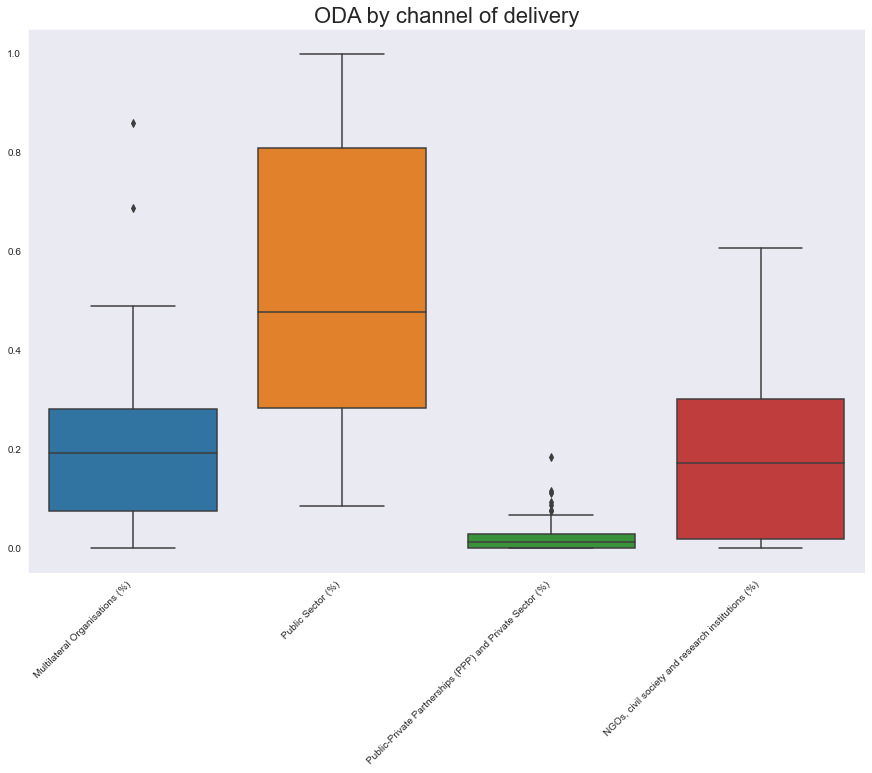

In [561]:
fig9, ax9 = plt.subplots(figsize=(15, 10)) 
sns.boxplot(data=channel_crs.loc[show_countries, :], ax = ax9)
plt.xticks(rotation=45, ha="right")
plt.title("ODA by channel of delivery", fontsize=22)
plt.show()

## 3.6 Multilateral ODA

This section is about the share of ODA that is multilateral, i.e. given by donors to multilateral organisations. Another variable is about the share of earmarked funding to multilateral organisations (i.e. money given to these organisations but with additional strings attached as to how they are allowed to spend it). Both share of multilateral aid and earmarked funding are useful variables for a typology of aid donors as they relate to important debates in the aid community (e.g. aid fragmentation).

In [562]:
multi_df = pd.read_csv("data/multilateral.csv", header=1, index_col=0)
multi_df.drop(axis=0, index='Donor(s)', inplace=True)
multi_df.drop(axis=1, columns=['Flow(s)'], inplace=True)
multi_df = multi_df.replace('..', "0").astype(float)

In [563]:
multi_df.head()

,ODA,I.A. Bilateral Official Development Assistance by types of aid (1+2+3+4+5+6+7+8+9+10),I.A. Memo: ODA channelled through multilateral organisations,I.B. Multilateral Official Development Assistance (capital subscriptions are included with grants),Unnamed: 6
"DAC Countries, Total",176879.25,128893.54,28425.42,47988.94,NaN
"Non-DAC Countries, Total",16265.67,14578.98,785.87,1686.70,NaN
"Multilateral Agencies, Total",24228.04,23977.10,4447.99,250.94,NaN
Australia,2868.76,2318.95,684.09,549.81,NaN
Austria,1328.22,568.21,161.41,760.01,NaN


In [564]:
multi_df['Bilateral'] = multi_df['I.A. Bilateral Official Development Assistance by types of aid (1+2+3+4+5+6+7+8+9+10)'] - multi_df['I.A. Memo: ODA channelled through multilateral organisations']
multi_df['earmarked_multilateral'] = multi_df['I.A. Memo: ODA channelled through multilateral organisations']
multi_df['core multilateral'] = multi_df['I.B. Multilateral Official Development Assistance (capital subscriptions are included with grants)']
multi_df['earmarked-to-core-ratio'] = multi_df['earmarked_multilateral']/multi_df['core multilateral']
multi_df['share of multilateral'] = (multi_df['earmarked_multilateral'] + multi_df['core multilateral'])/multi_df['ODA']
multi_df['earmarked-to-core-ratio log'] = multi_df['earmarked-to-core-ratio'].apply(lambda x: np.log10(1 + x))

In [565]:
excluded_donors = ['Multilateral Agencies, Total', 'EU Institutions', 'G7 Countries, Total']
include_donors = [donor for donor in multi_df.index if donor not in excluded_donors]

final_multi_df = multi_df.loc[include_donors, ['earmarked-to-core-ratio', 'earmarked-to-core-ratio log', 'share of multilateral']]
final_multi_df.dropna(inplace=True)

In [566]:
final_multi_df.head()

,earmarked-to-core-ratio,earmarked-to-core-ratio log,share of multilateral
"DAC Countries, Total",0.592333,0.202034,0.432014
"Non-DAC Countries, Total",0.465922,0.166111,0.152012
Australia,1.244230,0.351067,0.430116
Austria,0.212379,0.083638,0.693725
Belgium,0.149264,0.060420,0.584088


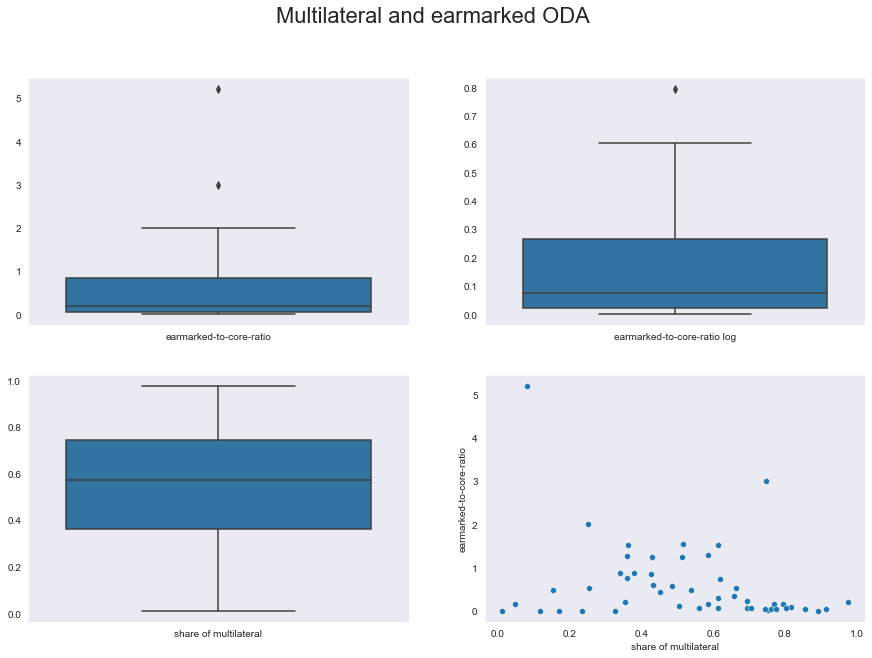

In [567]:
show_countries = [donor for donor in final_multi_df.index if donor not in ['DAC Countries, Total', 'Non-DAC Countries, Total']]

fig10, ax10 = plt.subplots(figsize=(15, 10), ncols=2, nrows=2) 
sns.boxplot(data=final_multi_df.loc[show_countries, ['earmarked-to-core-ratio']], ax = ax10[0, 0])
sns.boxplot(data=final_multi_df.loc[show_countries, ['earmarked-to-core-ratio log']], ax = ax10[0, 1])
sns.boxplot(data=final_multi_df.loc[show_countries, ['share of multilateral']], ax = ax10[1, 0])
sns.scatterplot(data=final_multi_df, x='share of multilateral', y='earmarked-to-core-ratio', ax=ax10[1, 1])
fig10.suptitle("Multilateral and earmarked ODA", fontsize=22)
plt.show()

## 2.7 Country-Programmable Aid

"Country programmable aid (CPA) is the portion of aid that providers can programme for individual countries or regions, and over which partner countries could have a significant say. Developed in 2007, CPA is a closer proxy of aid that goes to partner countries than the concept of official development assistance (ODA)" ([quoted from here](https://www.oecd.org/dac/financing-sustainable-development/development-finance-standards/cpa.htm)). In other words, CPA is funding that is more reliable over the long term and over which partner countries have more control. For instance, it excludes short-term finance to react to crisis situations (e.g. disaster relief) or debt relief.

In [568]:
cpa_df = pd.read_csv("data/cpa.csv")

In [569]:
mask_bil = (oda_data['Aid type'] == 'I.A. Bilateral Official Development Assistance by types of aid (1+2+3+4+5+6+7+8+9+10)') & (oda_data['Fund flows'] == "Gross Disbursements") \
                & (oda_data['Amount type'] == "Constant Prices")

bilateral_oda = oda_data.loc[mask_bil, ['Donor', 'Value']]
bilateral_oda.rename(columns={'Value': 'bilateral ODA'}, inplace=True)

In [570]:
cpa_df = cpa_df.loc[:, ['Donor', 'Value']]
# cpa_df = cpa_df.merge(multi_df.reset_index().rename(columns={'index': 'Donor'}), on='Donor', how='inner')
cpa_df = cpa_df.merge(bilateral_oda, on='Donor', how='inner')
cpa_df['share of cpa'] = cpa_df['Value'] / cpa_df['bilateral ODA']
cpa_df = cpa_df.loc[:, ["Donor", "share of cpa"]]
cpa_df['share of cpa, log'] = cpa_df.loc[:, ["share of cpa"]].apply(lambda x: np.log10(1 + x))

In [571]:
cpa_df.head()

,Donor,share of cpa,"share of cpa, log"
0,"DAC Countries, Total",0.497392,0.175335
1,Australia,0.650107,0.217512
2,Austria,0.142217,0.057749
3,Belgium,0.191452,0.076077
4,Canada,0.231156,0.090313


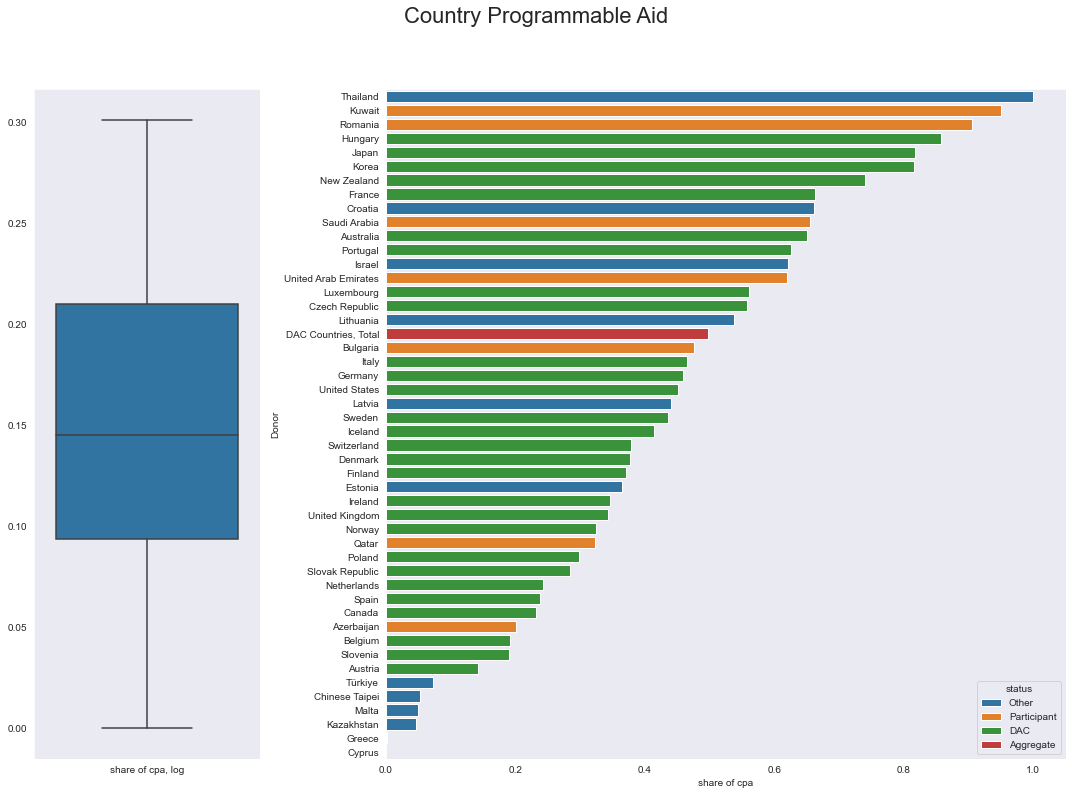

In [572]:
show_countries = cpa_df['Donor'] != 'DAC Countries, Total'

fig10, (ax10a, ax10b) = plt.subplots(figsize=(15, 10), ncols=2, gridspec_kw={'width_ratios': [1, 3]}) 
sns.boxplot(data=cpa_df.loc[show_countries, ['share of cpa, log']], ax = ax10a)
sns.barplot(data=cpa_df.sort_values('share of cpa', ascending=False).merge(oda_main, on='Donor'), y='Donor',
            x='share of cpa', hue='status', dodge=False, ax=ax10b)
fig10.tight_layout()
fig10.suptitle("Country Programmable Aid", size=22, y=1.1)
plt.show()

## 3.8 Putting everything together

In [573]:
# we create a consolidated dataframe with all dfs from above
dfs = [
    oda_main,
    regions_df,
    income_df,
    other_groups,
    sectors_df,
    type_crs,
    channel_crs,
    final_multi_df,
    cpa_df
]

def create_dataset(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    for df in dfs:
        if "Donor" not in df.columns:
            df.reset_index(inplace=True)
            df.rename(columns={'index': 'Donor'}, inplace=True)
    data = reduce(lambda df1, df2: pd.merge(df1, df2, on='Donor', how='inner'), dfs)
    data.set_index('Donor', inplace=True)  
    return data


data = create_dataset(dfs)

In [574]:
data.head()

,"ODA, grant equivalent measure",ODA grant equivalent as percent of GNI,status,"ODA, grant equivalent measure (log)",ODA as percent of GNI (log),Europe (%),South & Central Asia (%),concentration_score,Asia-Pacific (%),MENA (%),...,Budget support and pooled funding (%),Multilateral Organisations (%),Public Sector (%),Public-Private Partnerships (PPP) and Private Sector (%),"NGOs, civil society and research institutions (%)",earmarked-to-core-ratio,earmarked-to-core-ratio log,share of multilateral,share of cpa,"share of cpa, log"
Donor,,,,,,,,,,,,,,,,,,,,,
Portugal,412.99,0.184026,DAC,2.615940,0.073361,0.003942,0.007349,-0.176091,0.286563,0.027449,...,0.067568,0.100425,0.810211,0.000111,0.081375,0.067361,0.028311,0.559086,0.625277,0.210927
Poland,829.25,0.143632,DAC,2.918685,0.058286,0.668239,0.086871,-0.698970,0.087994,0.054755,...,0.090818,0.074133,0.497883,0.000002,0.146516,0.031365,0.013413,0.744255,0.297873,0.113232
Lithuania,72.02,0.132920,Other,1.857453,0.054199,0.678487,0.209220,-0.602060,0.010638,0.048463,...,0.231403,0.127522,0.502363,0.077211,0.275670,0.025283,0.010844,0.855873,0.537298,0.186758
Sweden,6348.62,1.138910,DAC,3.802679,0.330193,0.094172,0.127685,-0.698970,0.022563,0.148028,...,0.528618,0.377506,0.168117,0.032382,0.354490,0.521446,0.182256,0.662147,0.436346,0.157259
Italy,4248.38,0.223411,DAC,3.628223,0.087572,0.079663,0.114799,-0.903090,0.042120,0.367006,...,0.302280,0.281483,0.496151,0.004776,0.196490,0.153686,0.062087,0.793441,0.464649,0.165733


In [575]:
print(f"The dataset contains {data.shape[0]} donors and {data.shape[1]} variables.")

The dataset contains 48 donors and 37 variables.


### 3.9 Select variables and donors to be included in the PCA

#### Variables (columns)

Features to keep for PCA:
We won't use all columns for the PCA, especially not those related to donors' absolute ODA and status. For some variables, we might pick the log transformed version. We can always go back to this section to try out PCA with different variables.

In [576]:
data.columns

Index(['ODA, grant equivalent measure',
       'ODA grant equivalent as percent of GNI', 'status',
       'ODA, grant equivalent measure (log)', 'ODA as percent of GNI (log)',
       'Europe (%)', 'South & Central Asia (%)', 'concentration_score',
       'Asia-Pacific (%)', 'MENA (%)', 'America (%)', 'Sub-Saharan Africa (%)',
       'poor country focus (%)', 'Fragile states (%)',
       'Land-Locked countries (%)', 'Small island states (%)', 'Education (%)',
       'Health, Water, Sanitation (%)', 'Government, Society and Peace (%)',
       'Transport, Communication and Energy (%)',
       'Banking, Finance and Business (%)',
       'Agriculture, Forestry, Fishing (%)',
       'Multi-Sector / Cross-Cutting (%)', 'Humanitarian Aid (%)',
       'Experts and other technical assistance (%)',
       'Project-type interventions (%)', 'in-donor expenditures (%)',
       'Budget support and pooled funding (%)',
       'Multilateral Organisations (%)', 'Public Sector (%)',
       'Public-Privat

In [577]:
# we won't use all columns for PCA, especially not those related to donors' absolute size, status
# here you can change what variables to include and iterate over the PCA repeatedly
cols_to_delete = [
        'ODA, grant equivalent measure',
        'ODA, grant equivalent measure (log)',
        'ODA grant equivalent as percent of GNI',
        'status',
        'earmarked-to-core-ratio',
        'America (%)',
        'Land-Locked countries (%)',
        'Small island states (%)',
        'share of cpa',
        'Public-Private Partnerships (PPP) and Private Sector (%)'
    ]

pca_data = data.drop(columns=cols_to_delete)

In [578]:
print(f"The data for the PCA contains {len(pca_data.columns)} variables.")

The data for the PCA contains 27 variables.


In [579]:

print(f"The variables retained for the PCA are: \n\n{pca_data.columns}")

The variables retained for the PCA are: 

Index(['ODA as percent of GNI (log)', 'Europe (%)', 'South & Central Asia (%)',
       'concentration_score', 'Asia-Pacific (%)', 'MENA (%)',
       'Sub-Saharan Africa (%)', 'poor country focus (%)',
       'Fragile states (%)', 'Education (%)', 'Health, Water, Sanitation (%)',
       'Government, Society and Peace (%)',
       'Transport, Communication and Energy (%)',
       'Banking, Finance and Business (%)',
       'Agriculture, Forestry, Fishing (%)',
       'Multi-Sector / Cross-Cutting (%)', 'Humanitarian Aid (%)',
       'Experts and other technical assistance (%)',
       'Project-type interventions (%)', 'in-donor expenditures (%)',
       'Budget support and pooled funding (%)',
       'Multilateral Organisations (%)', 'Public Sector (%)',
       'NGOs, civil society and research institutions (%)',
       'earmarked-to-core-ratio log', 'share of multilateral',
       'share of cpa, log'],
      dtype='object')


#### Donors (rows)

We exclude the aggregates: DAC, Participant and Other.

We can also exclude individual countries if their influence on the PCA is too strong. That depends on our interpretation of the PCA results. We first do it with all available donor countries.

In [580]:
pca_data = pca_data[data['status'] != "Aggregate"]

In [581]:
pca_data.index

Index(['Portugal', 'Poland', 'Lithuania', 'Sweden', 'Italy', 'Austria',
       'Greece', 'Estonia', 'Slovenia', 'Spain', 'Türkiye', 'Malta',
       'Australia', 'Belgium', 'Norway', 'Ireland', 'Czech Republic', 'Japan',
       'Germany', 'Iceland', 'Switzerland', 'United States', 'United Kingdom',
       'United Arab Emirates', 'Denmark', 'Finland', 'France', 'Latvia',
       'Israel', 'Canada', 'Hungary', 'Slovak Republic', 'Netherlands',
       'Luxembourg', 'New Zealand', 'Korea', 'Bulgaria', 'Romania', 'Croatia',
       'Chinese Taipei', 'Kuwait', 'Kazakhstan', 'Saudi Arabia', 'Azerbaijan',
       'Cyprus', 'Thailand', 'Qatar'],
      dtype='object', name='Donor')

In [582]:
# in case we want to repeat the analysis with a different set of donors
exclude_donors = []

pca_data.drop(index=exclude_donors, inplace=True)

In [583]:
print(f"The data for the PCA contains {len(pca_data.index)} donor countries.")

The data for the PCA contains 47 donor countries.


### 3.10 Extreme values

We will apply sklearn's Standard Scaler before the PCA. All variables will have a mean of 0 and a standard deviation of 1.

We can already have a look at the scaled data to identify extreme values.

In [584]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(pca_data)
scaled_df = pd.DataFrame(scaled_data, index=pca_data.index, columns=pca_data.columns)

In [585]:
extreme_counts = (
    (scaled_df > scaled_df.quantile(0.75) + 1.5 * (scaled_df.quantile(0.75) - scaled_df.quantile(0.25))) | (scaled_df < scaled_df.quantile(0.25) - 1.5 * (scaled_df.quantile(0.75) - scaled_df.quantile(0.25)))
).sum(axis=1)

In [586]:
extremes_df = pd.DataFrame(extreme_counts, index=scaled_df.index, columns=['nr of extreme values'])
extremes_df['status'] = data['status'][data['status'] != "Aggregate"]

In [587]:
extremes_df.head()

,nr of extreme values,status
Donor,,
Portugal,2,DAC
Poland,2,DAC
Lithuania,1,Other
Sweden,0,DAC
Italy,0,DAC


In [588]:
extremes_by_group = extremes_df.groupby('status').mean()
extremes_by_group.columns = ['average extreme values']

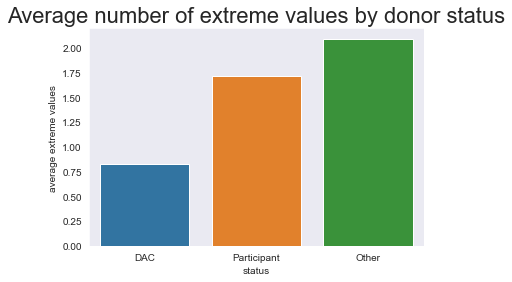

In [589]:
fig11, ax11 = plt.subplots()
sns.barplot(data=extremes_by_group.reset_index().sort_values('average extreme values'), x='status', y='average extreme values', ax=ax11)
plt.title("Average number of extreme values by donor status", fontsize=22)
plt.show()

This picture of extreme values seems plausible. As the largest group of countries in the dataset, DAC donors define what "normal" data looks like. They also have adapted their practice to their standards for a longer time and/or have defined standards (and the data reporting that comes with it) according to their practices. It also seems plausible that "Participants" are less "extreme" compared to DAC donors than "other" donors.

Considering these numbers, we could ask if conducting a PCA on all countries will only lead to a typology that differentiates between precisely these three groups. Moreover, it can be expected that donors with more extreme values will have a greater influence on the PCA. We will get back to this when interpreting the results of the first round of PCA. In the end, we will compare the PCA with all countries with another PCA conducted only on the DAC donors. 

## 3.11 Correlations

For PCA to reduce dimensionality, variables need to be correlated to some extend. In this dataset, there are only a small number of high correlations. Most variables are moderately or weakly correlated with other variables in the data set.

In [590]:
corr_matrix = scaled_df.corr()

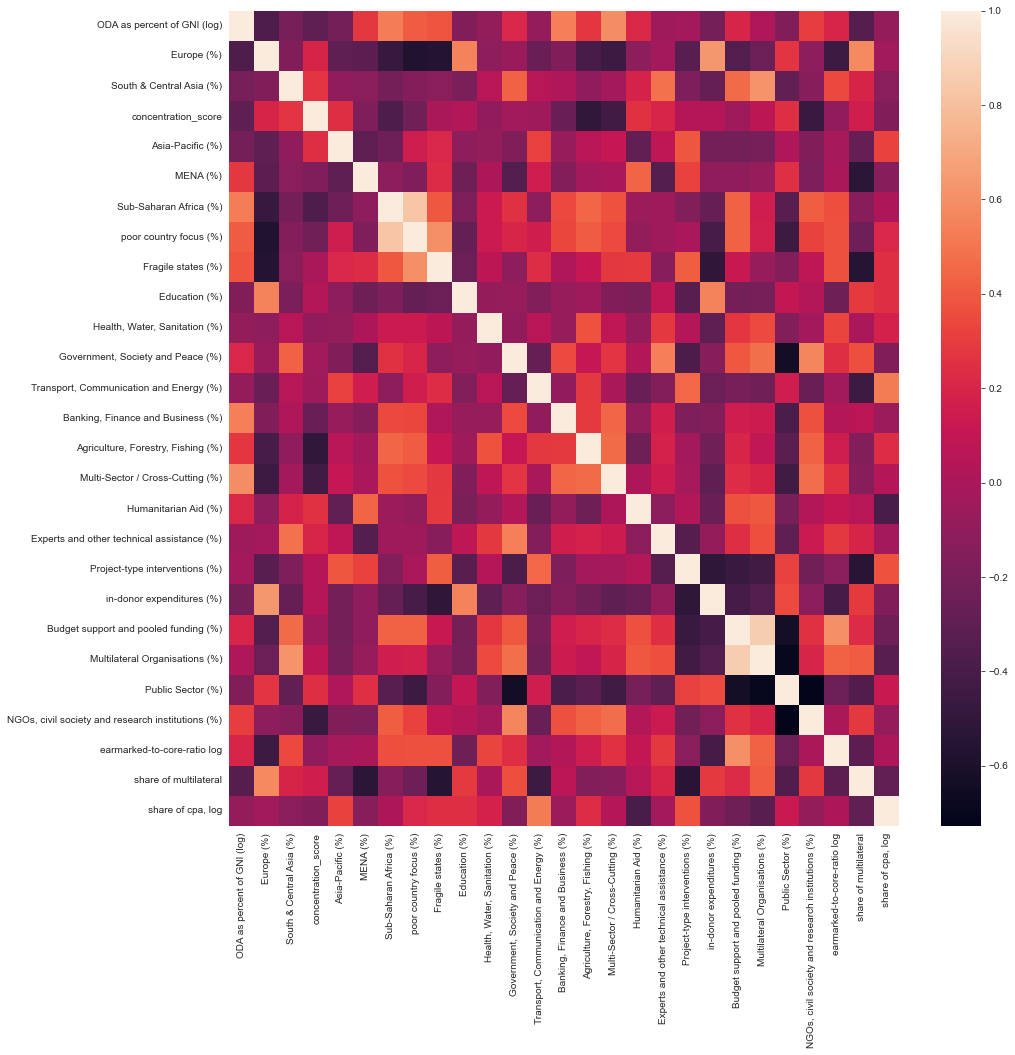

In [591]:
fig12, ax12 = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, ax=ax12)
plt.show()

Some high (positive or negative) correlations.

In [592]:
corr_threshold = 0.7
high_correlations = set()

for i in range(len(corr_matrix.index)):
    for c in range(len(corr_matrix.columns)):
        if (i != c) and (abs(corr_matrix.iloc[i, c]) >= corr_threshold):
            high_correlations.add(tuple(sorted([i, c])))

            
for i, c in high_correlations:
    corr = corr_matrix.iloc[i, c].round(2)
    if corr > 0:
        print(f"{corr_matrix.index[i]} is positively correlated with {corr_matrix.columns[c]}: {corr}")
    elif corr < 0:
        print(f"{corr_matrix.index[i]} is negatively correlated with {corr_matrix.columns[c]}: {corr}")
    

Public Sector (%) is negatively correlated with NGOs, civil society and research institutions (%): -0.73
Sub-Saharan Africa (%) is positively correlated with poor country focus (%): 0.83
Budget support and pooled funding (%) is positively correlated with Multilateral Organisations (%): 0.87


### Are some variables just proxies for donor size?

In [593]:
data_with_total_oda = pca_data.copy()
data_with_total_oda['Donor size log'] = np.log10(data['ODA, grant equivalent measure'])

In [594]:
scaler2 = StandardScaler()

scaled_data_with_total_oda = scaler2.fit_transform(data_with_total_oda)
scaled_data_with_total_oda = pd.DataFrame(scaled_data_with_total_oda, index=data_with_total_oda.index, columns=data_with_total_oda.columns)

In [595]:
corr_matrix2 = scaled_data_with_total_oda.corr()

In [596]:
for idx, value in zip(corr_matrix2['Donor size log'].index, corr_matrix2['Donor size log']):
    if abs(value) >= 0.6 and idx != 'Donor size log':
        print(f"{idx} is correllated with donor size: {value}")

Multi-Sector / Cross-Cutting (%) is correllated with donor size: 0.6500206565955413


Larger donors might be in a better position to spend funds for cross-cutting purposes. The category "Multi-Sector / Cross-Cutting (%)" refers to areas like environmental protection and other global issues for which the smallest donors might not have the necessary financial bandwidth in their bilateral cooperation.

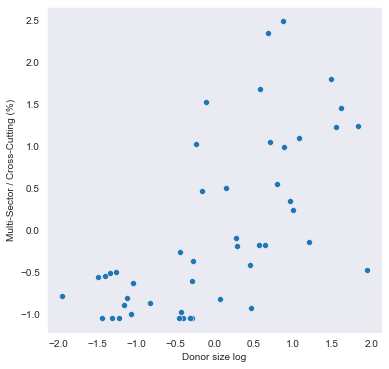

In [597]:
fig13, ax13 = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=scaled_data_with_total_oda["Donor size log"],
                y=scaled_data_with_total_oda["Multi-Sector / Cross-Cutting (%)"],
                ax=ax13)
plt.show()

## 4. Principal Component Analysis (PCA)

In [598]:
# standard scale the data before the PCA
scaler = StandardScaler()
scaled_pca_data = scaler.fit_transform(pca_data)

In [599]:
pca = PCA()

In [600]:
transformed_data = pca.fit_transform(scaled_pca_data)

In [601]:
transformed_df = pd.DataFrame(transformed_data, index=pca_data.index, columns=[str(nr) for nr in range(len(pca_data.columns))])
transformed_df.reset_index(inplace=True)

In [602]:
transformed_df.head()

,Donor,0,1,2,3,4,5,6,7,8,...,17,18,19,20,21,22,23,24,25,26
0,Portugal,1.500226,1.685072,-0.311503,-0.677608,-1.089454,2.729091,0.473669,-0.042415,0.002422,...,0.057115,-0.459401,0.046879,0.097627,-0.234256,-0.215942,-0.332283,0.077471,0.065517,-0.168384
1,Poland,2.860869,-1.935987,-1.795431,0.056098,0.375895,0.157121,0.423107,0.800086,-0.489289,...,-0.087167,1.031821,0.782797,0.019417,0.133765,-0.042533,0.227205,0.060137,-0.167910,0.060059
2,Lithuania,2.091857,-2.374359,-0.494368,-0.627339,-0.383310,-0.408270,0.544454,0.660336,-1.028426,...,-0.938304,-0.302157,-0.121687,-0.175009,-0.314541,-0.020564,0.257623,0.128734,-0.043048,-0.008351
3,Sweden,-3.900148,-0.724507,-1.091155,0.824983,-0.861948,0.171652,-0.049679,0.137438,-0.609020,...,-0.152540,0.745466,-0.366794,0.354269,-0.009870,-0.260708,-0.024776,-0.040414,-0.074339,0.008821
4,Italy,-0.634799,0.258849,-0.913726,0.232627,1.108510,-1.036510,0.962884,-0.618677,-0.223192,...,0.003493,-0.154330,0.379532,1.071101,-0.067169,0.027538,0.027133,-0.101259,0.000012,-0.055699


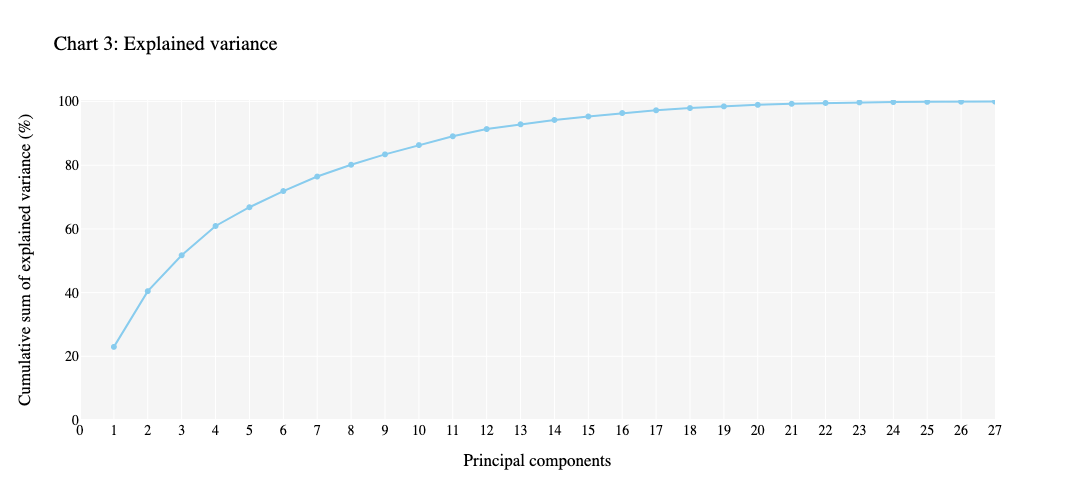

In [603]:
explained_variance_cumsum = pca.explained_variance_ratio_.cumsum() * 100
component_nr = list(range(1, len(explained_variance_cumsum) + 1))

fig14 = go.Figure(data=go.Scatter(
                            x=component_nr,
                            y=explained_variance_cumsum,
                            mode='lines+markers',
                            marker=dict(color=px.colors.qualitative.Safe[0]),
                            hovertemplate="Up to Component %{x}: %{y:.2f}%",
                            name='Explained variance'
                        )
     )


fig14.update_layout(title='Chart 3: Explained variance', font_family='Montserrat', font_color='black',
                    font_size=14, plot_bgcolor='rgb(245, 245, 245)', yaxis_range=[0, 100.5], xaxis_range=[0, len(explained_variance_cumsum)],
                    width=600, height=500)
fig14.update_xaxes(title="Principal components", tickmode='linear', tick0=1)
fig14.update_yaxes(title="Cumulative sum of explained variance (%)")
fig14.show()

In [604]:
kept_donors = ~data.reset_index()['Donor'].isin(exclude_donors)

original_data = data.reset_index().loc[kept_donors, :]

transformed_df['size'] = original_data[original_data['status'] != 'Aggregate']['ODA, grant equivalent measure'].values
transformed_df['status'] = original_data[original_data['status'] != 'Aggregate']['status'].values

In [605]:
def create_3D_scatterplot(df, chart_nr):
    status_in_order = list(df['status'].unique())
    status_colors = px.colors.qualitative.Safe[:len(status_in_order)]

    fig = go.Figure()

    for status, color in zip(status_in_order, status_colors):
        trace_mask = df['status'] == status
        trace_data = df.loc[trace_mask, :]
        
        if (len(status_colors) == 1) and ('color' in df.columns):
            marker = dict(
                        color=trace_data['color'],
                        sizemin=20,
                        sizemode='area',
                        sizeref=15,
                        size=trace_data['size'],
                        colorbar=dict(
                                title="Quality of representation (%)",
                            ),
                        colorscale="RdBu",
                        reversescale=True
                    )
            show_legend = False
        else:
            marker = dict(
                        color=color,
                        sizemin=20,
                        sizemode='area',
                        sizeref=15,
                        size=trace_data['size'],
                    )
            show_legend=True
        
        fig.add_trace(
            go.Scatter3d(x=trace_data['0'],
                         y=trace_data['1'],
                         z=trace_data['2'],
                         name=status,
                         mode='markers',
                         marker=marker,
                         text=trace_data['Donor'],
                         hovertemplate="%{text} <br>(%{x}, %{y}, %{z})",
                         legendgroup=status,
                         showlegend=show_legend
                    )
        )

    fig.update_layout(
        scene = dict(
            xaxis = dict(title="PC1", backgroundcolor='rgb(245, 245, 245)'),
            yaxis = dict(title="PC2", backgroundcolor='rgb(245, 245, 245)'),
            zaxis = dict(title="PC3", backgroundcolor='rgb(245, 245, 245)'),
        ),
        title=f'Chart {chart_nr}: 3D scatter plot of aid donors (2020)',
        legend=dict(title='Status', font=dict(size=16)),
        width=700,
        height=500,
        font_family='Montserrat',
        font_color='black',
        font_size=14,
    )
    return fig


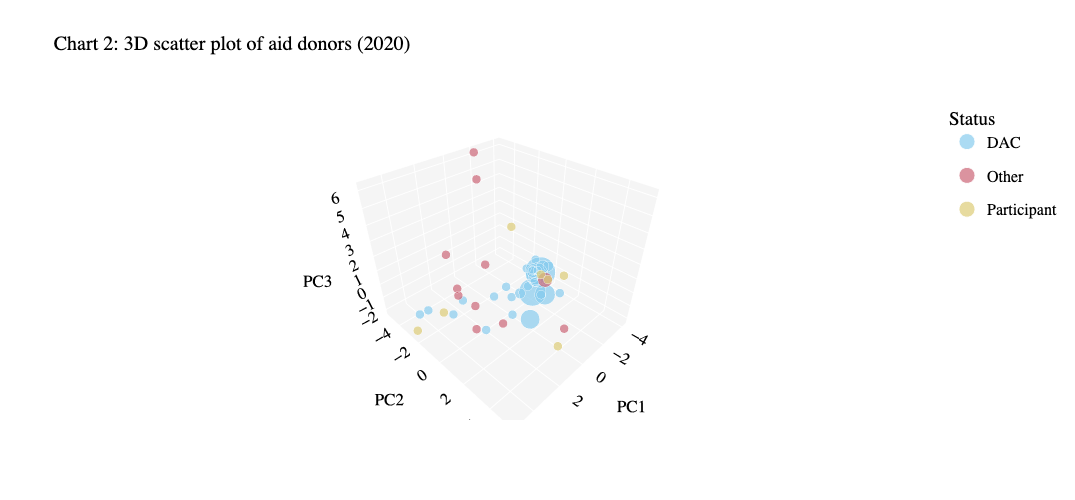

In [606]:
fig15 = create_3D_scatterplot(transformed_df, 2)
fig15.show()

The 3D scatterplot is interesting enough and allows us to get a first feeling of the similarities and differences between the donors in our data set. As the explained variance for the first three components is only roughly 50%, we need to be careful when drawing conclusions. A thorough interpretation of the results of our PCA is important to get a better idea of the quality of our 3D representation and ideas for changing our data set in view of a next iteration of PCA.

We can also see that the initial concern that donors might simply be divided according to their status as DAC, Participant or Other is not completely unfounded, at least when looking at the space where most of the DAC donors concentrate. As mentioned earlier, this might be a good reason to run the PCA also on the DAC-only group to get a better idea of intra-DAC differences.

## 5. Interpretation of the results

### 5.1 Correlation circles: What do the axes in the 3D-representation mean?

Correlation circles show how the original variables relate to the axes of the 3D scatter plot. They are based on the correlations of the original variables with the principal components.

In [607]:
scaled_df = pd.DataFrame(scaled_pca_data, index=pca_data.index, columns=pca_data.columns)

In [608]:
def calculate_var_corrs(dims: tuple[int, int], X: np.ndarray, Xpca: np.array,
                        var_names: list[str], ev: np.array, threshold: float = 0.0):
    arrow_coords = []
    dim1, dim2 = dims
    ve1, ve2 = np.round(ev[dim1] * 100, 1), np.round(ev[dim2] * 100, 1)
    col_name1 = f"PC {dim1 + 1} ({ve1}%)"
    col_name2 = f"PC {dim2 + 1} ({ve2}%)"

    for i,j in enumerate(X.T):
        corr1 = np.corrcoef(j, Xpca[:, dim1])[0,1]
        corr2 = np.corrcoef(j, Xpca[:, dim2])[0,1]
        arrow_coords.append((corr1, corr2))
        
    corr_circle_df = pd.DataFrame(index=var_names)
    corr_circle_df[col_name1] = [a[0] for a in arrow_coords]
    corr_circle_df[col_name2] = [a[1] for a in arrow_coords]
    min_corr = (abs(corr_circle_df[col_name1]) >= threshold) | (abs(corr_circle_df[col_name2]) >= threshold) 
    return corr_circle_df.loc[min_corr, :]

In [609]:
X = scaled_data.copy()

Xpca = transformed_df.set_index('Donor').iloc[:, :-2].values # exclude columns for absolute ODA and status

var_names = scaled_df.columns

In [610]:
def create_correlation_circle(var_corrs):
    
    fig = go.Figure()
    
    fig.add_shape(type="circle",
                  xref="x", yref="y",
                  x0=-1, y0=-1, x1=1, y1=1,
                  line_color="black",
                )
    
    fig.update_xaxes(range=[-1.1, 1.1], zeroline=False)
    fig.update_yaxes(range=[-1.1, 1.1])
    
    for i, var in enumerate(var_corrs.index):
        x, y = var_corrs.iloc[i, :]
        fig.add_trace(go.Scatter(
            x = [0, x],
            y = [0, y],
            mode='lines',
            marker=dict(color='black'),
            showlegend=False,
            hovertemplate=f"{var_corrs.index[i]}<br>({np.round(x, 2)}; {np.round(y, 2)})",
            name=''
            )
        )
    
    for i, var in enumerate(var_corrs.index):
        x, y = 1.01 * var_corrs.iloc[i, :]
        fig.add_annotation(
            ax=0,
            ay=0,
            x=x,
            y=y,
            axref='x',
            ayref='y',
            xref='x',
            yref='y',
            arrowhead=2,
            arrowsize=3,
            arrowcolor='black',
            showarrow=True
        )

    fig.update_layout(
        title='PCA',
        width=600,
        height=600,
        font_family='Montserrat',
        font_color='black',
        font_size=14,
    )
    
    dim1, dim2 = var_corrs.columns[0].split(" ")[1], var_corrs.columns[1].split(" ")[1]
    title = f"Correlation Circle ({dim1}, {dim2})"
    fig.update_layout(title=title, font_family='Montserrat', font_color='black',
                     font_size=14, plot_bgcolor='rgb(245, 245, 245)', width=600, height=600)

    fig.update_xaxes(title=f"{var_corrs.columns[0]}")
    fig.update_yaxes(title=f"{var_corrs.columns[1]}")

    
    return fig

Have a look at the following two correlation circles. You can hover over the arrowheads to read the names of the variables.

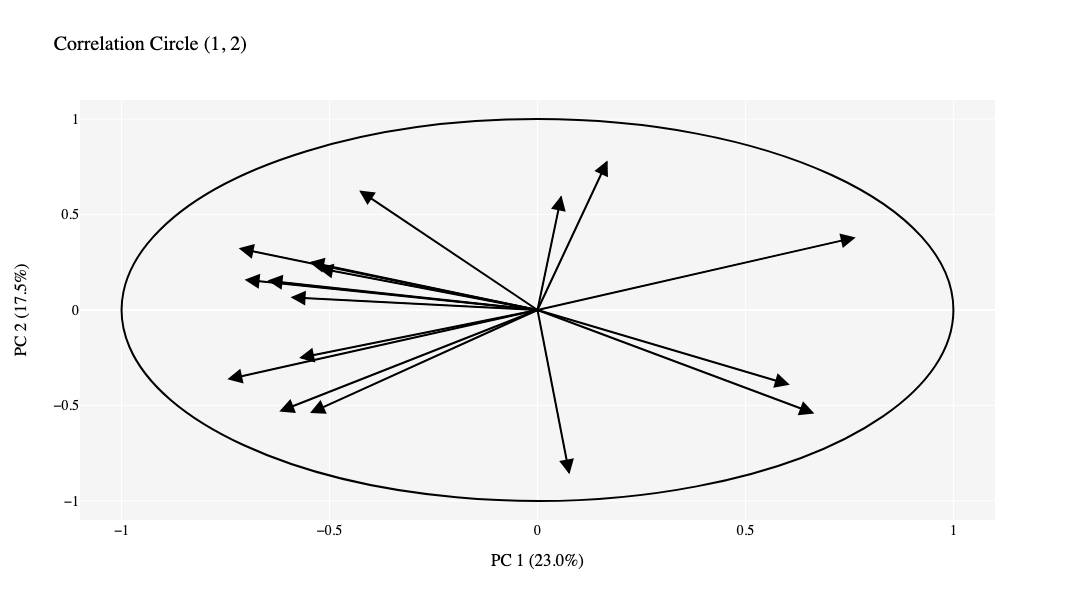

In [611]:
var_corr_df1 = calculate_var_corrs((0, 1), X, Xpca, var_names, pca.explained_variance_ratio_, 0.5)
fig16 = create_correlation_circle(var_corr_df1)
fig16.show()

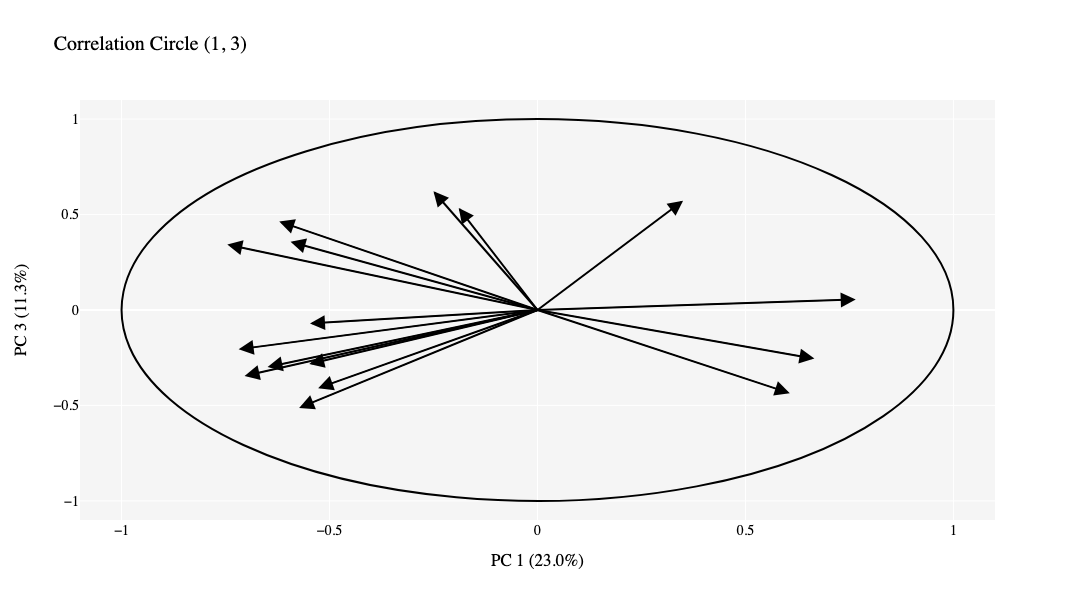

In [612]:
var_corr_df2 = calculate_var_corrs((0, 2), X, Xpca, var_names, pca.explained_variance_ratio_, 0.5)
fig17 = create_correlation_circle(var_corr_df2)
fig17.show()

### 5.2 Donors

With regard to the donors, we'll look into two things:
- the contribution of donors to the PCA: this is another way of identifying extreme cases that might influence the PCA results more than they should
- assessing the quality of donors' representation with the first three components: this is helpful to find out if we can really trust the position of specific donors in the 3D plot

#### Contribution of each donor to the first three PCA dimensions

In [613]:
def get_contributions(Xpca: np.array, donors: list[str]) -> pd.DataFrame:
    contributions = (Xpca**2 / sum(Xpca**2)) * 100
    contr_df = pd.DataFrame(contributions[:, :3], index=donors)
    avg_expected_contribution = np.round(100/len(donors), 2)
    contr_df['avg_expected'] = avg_expected_contribution
    return contr_df

In [614]:
contribution = (transformed_data**2 / sum(transformed_data**2)) * 100

In [615]:
contributions = pd.DataFrame(contribution[:, :3], index=pca_data.index)

In [616]:
avg_expected_contribution = np.round(100/len(pca_data.index), 2)
contributions['avg_expected'] = avg_expected_contribution
contributions = contributions.reset_index().merge(
    oda_main[['Donor', 'status']], on='Donor')

print(f"Average expected contribution by each donor: {avg_expected_contribution}")

Average expected contribution by each donor: 2.13


In [617]:
contributions.round(2).head()

,Donor,0,1,2,avg_expected,status
0,Portugal,0.77,1.28,0.07,2.13,DAC
1,Poland,2.81,1.69,2.26,2.13,DAC
2,Lithuania,1.50,2.54,0.17,2.13,Other
3,Sweden,5.22,0.24,0.83,2.13,DAC
4,Italy,0.14,0.03,0.58,2.13,DAC


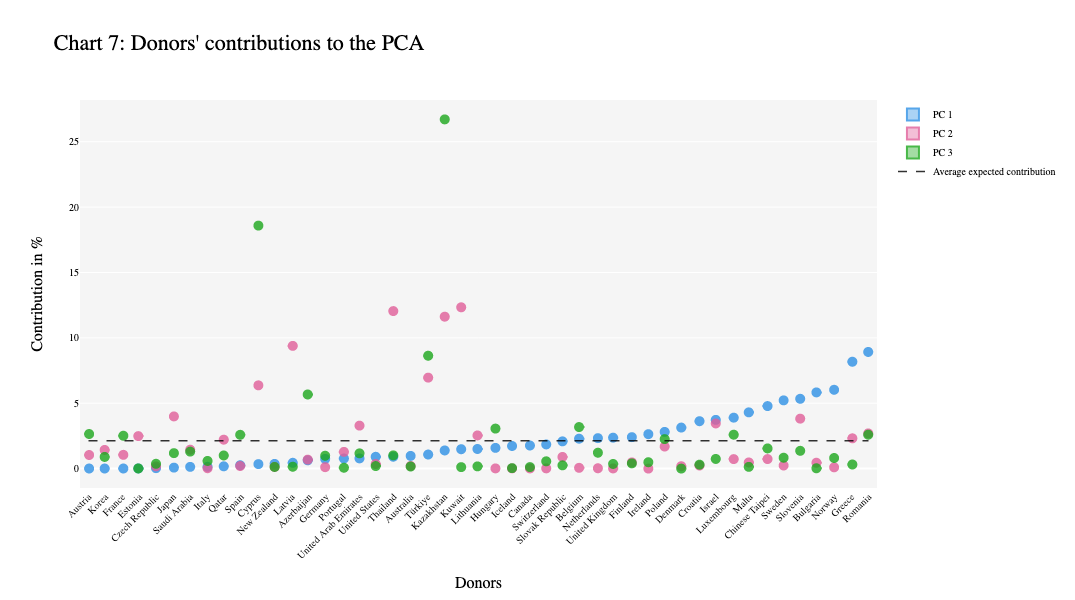

In [618]:
def show_contributions(contributions):
    fig = go.Figure()
    pc_dims = [0, 1, 2]
    contributions = contributions.sort_values(0)

    for pc_dim in pc_dims:
        fig.add_trace(go.Box(
            x=contributions['Donor'],
            y=contributions[pc_dim],
            name=f"PC {pc_dim + 1}",
            opacity=0.8,
            hovertemplate="%{x} contributes %{y:.2f}%",
            boxpoints='all',
            pointpos = 0,
            marker_color=px.colors.qualitative.Dark24[pc_dim],
            marker=dict(size=10),
            width=0,
        ))

    fig.add_trace(go.Scatter(
        x=contributions['Donor'],
        y=contributions['avg_expected'],
        mode='lines',
        name=f"Average expected contribution",
        opacity=0.8,
        line=dict(color='black', width=1.5, dash='dash'),
        hoverinfo='skip'
    ))

        
    fig.update_layout(
            title=dict(text="Chart 7: Donors' contributions to the PCA", font=dict(size=22)),
            width=900,
            height=600,
            font_family='Montserrat',
            font_color='black',
            font_size=10,
            plot_bgcolor='rgb(245, 245, 245)',
    )

    fig.update_xaxes(tickangle=-45 ,title=dict(text="Donors", font=dict(size=16)))
    fig.update_yaxes(title=dict(text="Contribution in %", font=dict(size=16)))
    return fig

fig18 = show_contributions(contributions)
fig18.show()

#### Quality of donor representation in the first three dimensions of the PCA

In [619]:
def get_cos2(scaled_data: np.array, Xpca: np.array, donors: list[str]) -> pd.DataFrame:
    d2 = (scaled_data**2).sum(axis=1)
    cos2 = (Xpca**2 /np.expand_dims(d2, axis=1)).round(2)
    cos2_df = pd.DataFrame(cos2)
    cos2_df['Donor'] = donors
    cos2_df['3D'] = cos2_df.iloc[:, :3].sum(axis=1)
    return cos2_df[['Donor', '3D']]

In [620]:
cos2_df = get_cos2(scaled_data, transformed_data, list(pca_data.index))

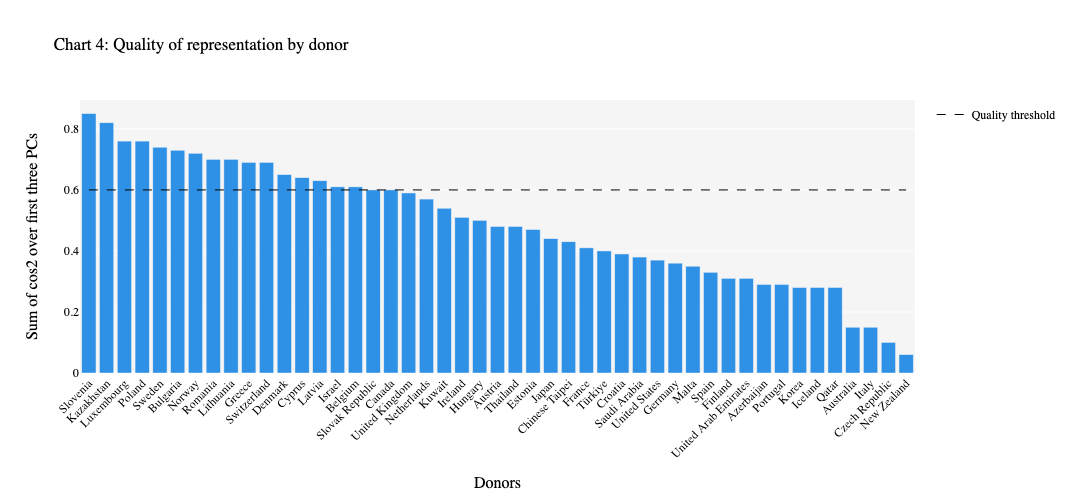

In [621]:
def create_cos2_chart(cos2_df):
    
    cos2_df.sort_values('3D', ascending=False, inplace=True)
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=cos2_df['Donor'],
        y=cos2_df['3D'],
        marker_color=px.colors.qualitative.Dark24[0],
        showlegend=False
    ))
    
    fig.add_trace(
        go.Scatter(
            x=cos2_df['Donor'],
            y=[0.6]*len(cos2_df['Donor']),
            mode="lines",
            line=dict(color='black', width=1, dash='dash'),
            hoverinfo='skip',
            name='Quality threshold'
        )
    )

    
    fig.update_layout(
        title="Chart 4: Quality of representation by donor",
        height=500,
        plot_bgcolor='rgb(245, 245, 245)',
        font_family='Montserrat',
        font_color='black',
        font_size=12
    )
    fig.update_xaxes(tickangle=-45, title=dict(text="Donors", font=dict(size=16)))
    fig.update_yaxes(title=dict(text="Sum of cos2 over first three PCs", font=dict(size=16)))
    return fig

fig19 = create_cos2_chart(cos2_df)
fig19.show()

## 6. Another round of PCA

Based on what we know about the results of our first attempt to conduct PCA on our data set, we can decide on what to change before doing another iteration of the same process. We have two main options:

- add/drop/change variables
- drop donors

In principle, there are numerous ways to adjust the data set and react to what we have learned so far. To keep it short, I will not touch the variables again here. As announced earlier, I'll try another round of PCA with only the DAC donors.

In [622]:
only_dac = data['status'] == 'DAC'
exclude_donors = [donor for donor in exclude_donors if donor in dac_members]

dac_pca_data = data.loc[only_dac, :].drop(columns=cols_to_delete, index=exclude_donors)

In [623]:
dac_scaler = StandardScaler()

dac_scaled = dac_scaler.fit_transform(dac_pca_data)

In [624]:
dac_pca = PCA()

dac_transformed_data = dac_pca.fit_transform(dac_scaled)

In [625]:
dac_transformed_df = pd.DataFrame(dac_transformed_data, index=dac_pca_data.index, columns=[str(nr) for nr in range(len(dac_pca_data.columns))])
dac_transformed_df.reset_index(inplace=True)
dac_transformed_df = dac_transformed_df.merge(data.reset_index()[['Donor', 'status', 'ODA, grant equivalent measure']], on='Donor').rename(columns={'ODA, grant equivalent measure': 'size'})

In [626]:
dac_transformed_df.head()

,Donor,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,24,25,26,status,size
0,Portugal,2.508422,2.302479,3.263597,1.028691,-1.393480,1.520413,-2.373553,0.147050,0.084607,...,0.097782,0.006056,0.065010,0.071759,0.087907,-0.016862,-0.002806,0.002708,DAC,412.99
1,Poland,4.846455,-1.345520,-0.179382,0.691162,1.148657,-0.669726,-0.298487,-0.896338,1.182006,...,0.316615,0.134062,0.323394,0.112446,-0.036477,0.012613,0.027204,0.002935,DAC,829.25
2,Sweden,-3.469148,-2.160775,-0.024258,-1.143573,-0.731497,-0.380524,-0.905865,-0.289571,-0.144601,...,0.005987,0.136528,0.067282,-0.235408,-0.011999,-0.106531,-0.012214,-0.014233,DAC,6348.62
3,Italy,-0.112499,-0.627362,-1.982642,2.346433,-0.365600,0.402503,1.286724,-0.550721,-0.752033,...,-0.153339,-0.218966,0.010139,0.092112,0.027787,-0.061827,0.012053,-0.027500,DAC,4248.38
4,Austria,1.689708,-1.670224,-1.876132,-0.255020,0.433886,0.192786,0.025859,-1.232191,-0.070568,...,-0.130678,0.221045,-0.100535,-0.213973,0.099293,0.049958,-0.001089,-0.009664,DAC,1273.35


In [627]:
dac_pca.explained_variance_ratio_.cumsum()

array([0.31965028, 0.49970079, 0.57946188, 0.6576654 , 0.72341118,
       0.76912185, 0.81320672, 0.84506596, 0.87679347, 0.90278804,
       0.92276787, 0.93814581, 0.95200659, 0.96339981, 0.97246957,
       0.98047756, 0.98545868, 0.98987862, 0.99337514, 0.99632927,
       0.99784899, 0.99876321, 0.99942992, 0.99980549, 0.99993738,
       0.99999319, 1.        ])

In [628]:
dac_scaled_df = pd.DataFrame(dac_scaled, index=dac_pca_data.index, columns=dac_pca_data.columns)

X = dac_scaled.copy()

Xpca = dac_transformed_df.set_index('Donor').iloc[:, :-2].values

var_names = dac_scaled_df.columns

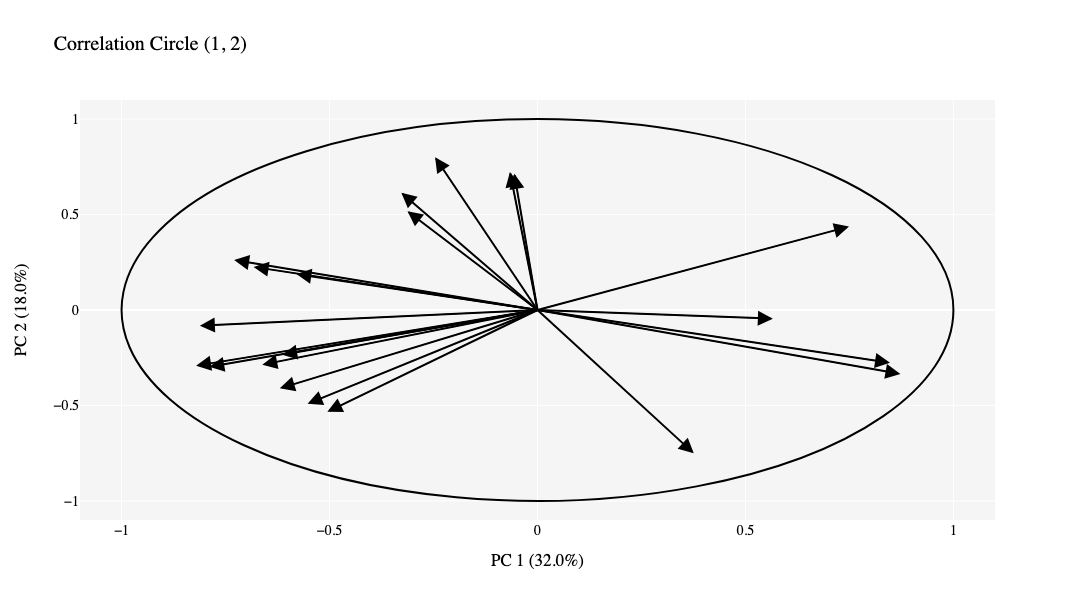

In [629]:
corr_df = calculate_var_corrs((0, 1), X, Xpca, var_names, dac_pca.explained_variance_ratio_, 0.5)
fig20 = create_correlation_circle(corr_df)
fig20.show()

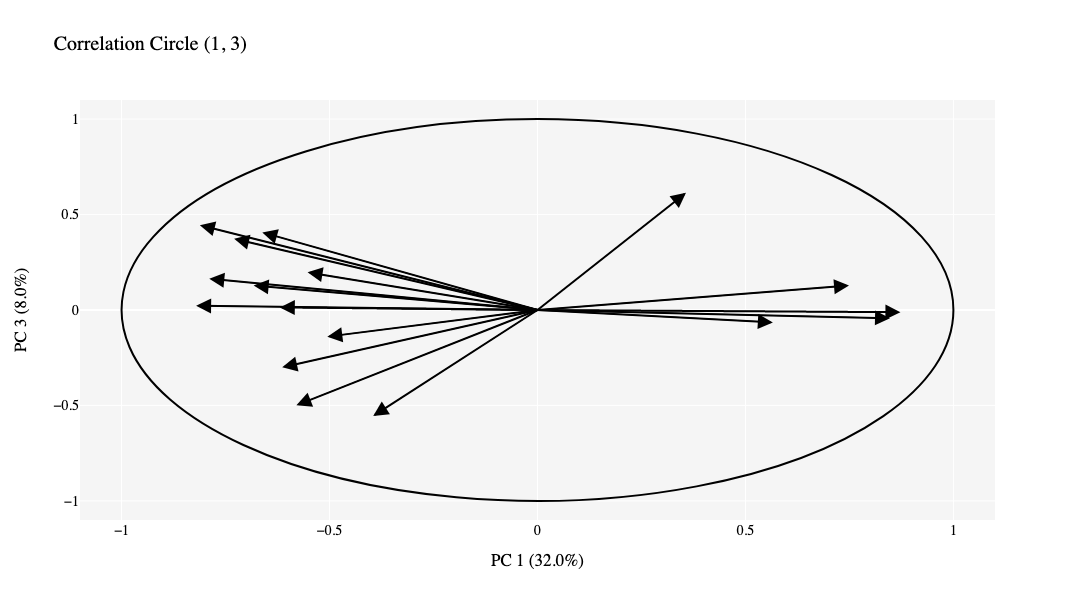

In [630]:
corr_df = calculate_var_corrs((0, 2), X, Xpca, var_names, dac_pca.explained_variance_ratio_, 0.5)
fig21 = create_correlation_circle(corr_df)
fig21.show()

In [631]:
dac_contributions = get_contributions(dac_transformed_data, list(dac_pca_data.index))

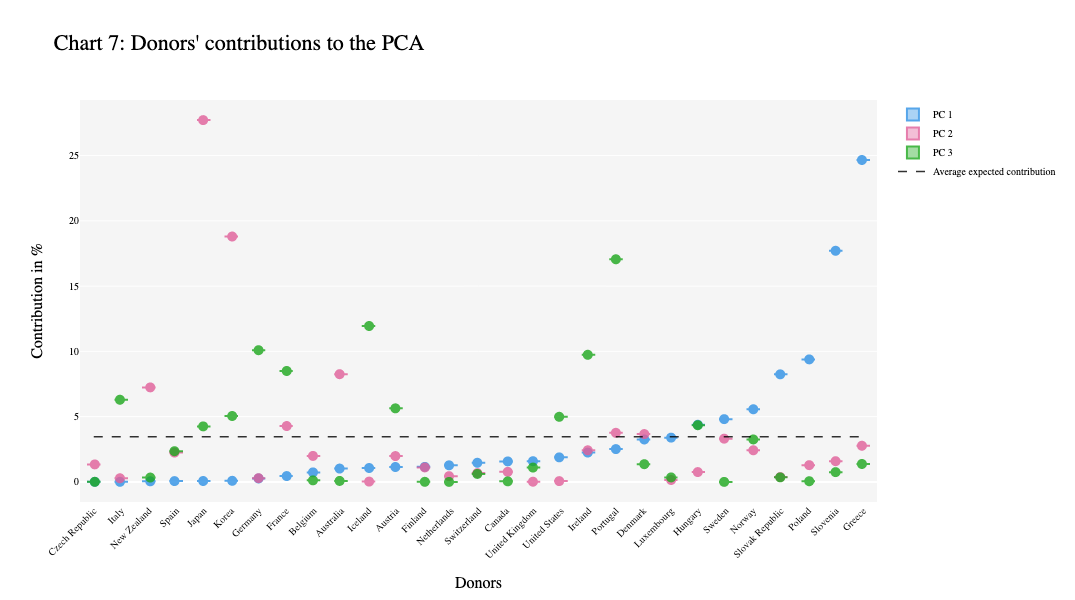

In [632]:
fig22 = show_contributions(dac_contributions.reset_index().rename(columns={'index': 'Donor'}))
fig22.show()

In [633]:
dac_cos2_df = get_cos2(dac_scaled, dac_transformed_data, list(dac_pca_data.index))

In [634]:
dac_transformed_df.merge(dac_cos2_df, on='Donor').rename(columns={'3D': 'color'})

,Donor,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,status,size,color
0,Portugal,2.508422,2.302479,3.263597,1.028691,-1.393480,1.520413,-2.373553,0.147050,0.084607,...,0.006056,0.065010,0.071759,0.087907,-0.016862,-0.002806,0.002708,DAC,412.99,0.59
1,Poland,4.846455,-1.345520,-0.179382,0.691162,1.148657,-0.669726,-0.298487,-0.896338,1.182006,...,0.134062,0.323394,0.112446,-0.036477,0.012613,0.027204,0.002935,DAC,829.25,0.75
2,Sweden,-3.469148,-2.160775,-0.024258,-1.143573,-0.731497,-0.380524,-0.905865,-0.289571,-0.144601,...,0.136528,0.067282,-0.235408,-0.011999,-0.106531,-0.012214,-0.014233,DAC,6348.62,0.69
3,Italy,-0.112499,-0.627362,-1.982642,2.346433,-0.365600,0.402503,1.286724,-0.550721,-0.752033,...,-0.218966,0.010139,0.092112,0.027787,-0.061827,0.012053,-0.027500,DAC,4248.38,0.24
4,Austria,1.689708,-1.670224,-1.876132,-0.255020,0.433886,0.192786,0.025859,-1.232191,-0.070568,...,0.221045,-0.100535,-0.213973,0.099293,0.049958,-0.001089,-0.009664,DAC,1273.35,0.58
5,Greece,7.856566,-1.976259,0.926038,-1.401301,-1.687534,-0.186539,0.921372,0.754099,-1.682634,...,0.076465,-0.016715,-0.035594,0.009507,0.013190,-0.009795,0.001527,DAC,325.44,0.84
6,Slovenia,6.656910,-1.495742,0.683845,-1.975880,0.320694,-0.390536,0.134178,-0.525335,1.007385,...,-0.293448,-0.200927,0.044456,-0.003428,-0.038517,-0.019110,-0.005355,DAC,90.73,0.85
7,Spain,0.393212,-1.779928,-1.211559,1.441458,1.727599,0.281853,-1.293927,1.197810,-1.401701,...,-0.008841,0.123603,0.264664,-0.157466,0.002672,-0.000942,-0.003840,DAC,2987.04,0.27
8,Australia,-1.598737,3.410966,0.214330,-1.924775,2.608290,-1.455776,-1.124464,0.096031,-1.325967,...,0.163011,-0.199303,-0.112612,-0.082323,0.057754,0.060842,-0.014987,DAC,2868.76,0.45
9,Belgium,-1.351332,-1.675237,0.272214,1.075918,0.155513,2.753302,0.369474,-0.482549,-1.282050,...,-0.206394,0.288215,-0.172517,-0.018743,0.033823,-0.011767,-0.000096,DAC,2343.58,0.26


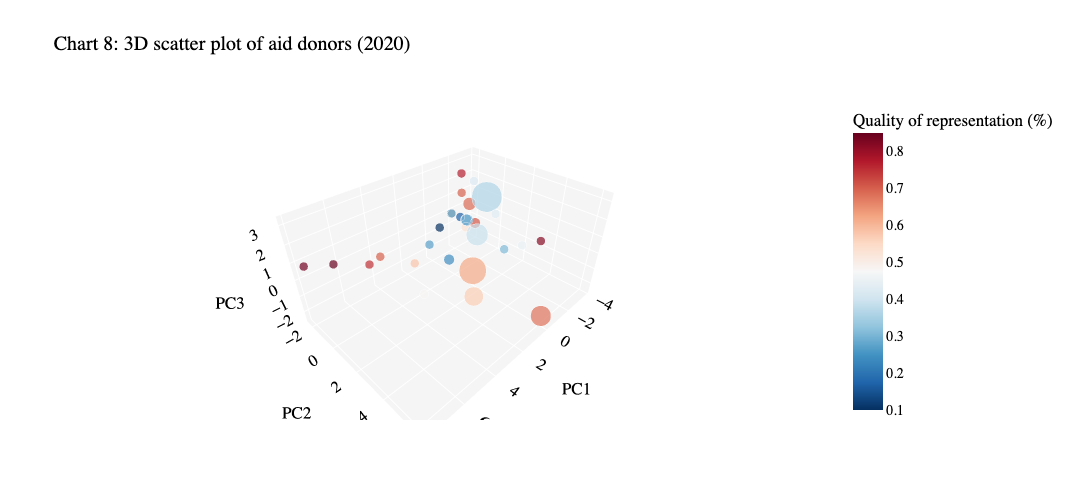

In [635]:
fig23 = create_3D_scatterplot(dac_transformed_df.merge(dac_cos2_df, on='Donor').rename(columns={'3D': 'color'}), 8)
fig23.show()

## 7. Conclusion

As for the objective of developing a typology, some groups of donors have emerged as likely belonging to the same groups, despite many caveats related to the interpretation of the results. Although the picture is still incomplete, commonly used labels like „Scandinavian donors“, the similarity of Japan and South Korea as donors, and a group of „Eastern European“ donors can already be confirmed as sensible categorisations by the PCA.

There is certainly much more we could do to make the PCA work better for the purpose of creating a good 3D-representation of aid donors. In particular, the selection of variables and donors could be worked out more diligently. Making better choices on using variables and donors as inputs to the PCA or merely as illustrative data can bring us a long way towards increasing the explained variance of the first three components. This process should be led by a sound theory of what a typology of aid donors should do. Above all, variables should not just be tweaked to make the method happy.

Otherwise, we just have to accept that we might need more than three PCs and different methods to make sense of the data. This is what I will do in the second part of this project. I will take the results of the two PCAs from this post (all donors and DAC-only) and use more of the PCs to perform clustering. To be continued soon.